# 🏡 House Price Prediction 📊 EDA + Prediction Ensumble Model 📈

![House Prices](https://storage.googleapis.com/kaggle-media/competitions/House%20Prices/kaggle_5407_media_housesbanner.png)

The goal of this challenge is to predict the sale price of residential homes in Ames, Iowa, using the given dataset. Accurate predictions of house prices are important for a variety of reasons, such as helping homeowners determine the value of their property, assisting real estate agents in pricing listings, and enabling banks to better estimate the risk associated with mortgage lending.

Our task is to build a robust and accurate machine learning model to predict house prices based on a set of features, such as the size of the house, the neighborhood, and other relevant attributes. The dataset contains 79 explanatory variables, which describe various aspects of residential homes and can be viewed in the [dataset description](https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques/data).

By the end of this notebook, we aim to achieve the following objectives:

1. Explore and visualise to investigate the distribution and analyse missing values within the dataset to understand the relationships between features and the target variable.
2. Preprocess the data, including handling missing values, feature engineering, and data scaling/transformation.
3. Select and evaluate multiple machine learning models to identify the most promising ones.
4. Optimize the chosen models by tuning hyperparameters and selecting the best features.
5. Use cross-validation and other evaluation techniques to assess the performance of our models.
6. Make predictions on the test dataset and create a submission file for the Kaggle competition.

# 1 Load Dataset

## Import libraries 

In [192]:
# Required Libraries
# Data wrangling and exploration
import pandas as pd
import numpy as np 
import scipy.stats
from scipy import stats
from scipy.stats import spearmanr
from feature_engine.creation import MathFeatures
import statsmodels.api as sm

# System
import os
import time
import warnings
from tqdm.notebook import tqdm

# Jupyter Notebook
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
%matplotlib inline

# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import MaxNLocator

# SKlearn
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler,  OneHotEncoder
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.linear_model import LinearRegression, Ridge

# Modelling 
from sklearn.ensemble import GradientBoostingRegressor, ExtraTreesRegressor, RandomForestRegressor, StackingRegressor, HistGradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor


In [193]:
# Visualisation Style Configuration 
palette = ['#009688', '#ff5722','#795548','#3f51b5','#673ab7','#2196f3','#8bc34a','#9e9e9e', '#8ac52a', '#643e67']
alpha = 0.5
_theme = sns.set_theme(style="whitegrid", font="sans-serif",palette=palette[0:2], font_scale=0.100, rc={'grid.color': '#d4d5d6', 'grid.linewidth': 0.25})
_fig = plt.figure(figsize=(15,7))
_context = sns.set_context('paper', font_scale=1.4)
sns.set(rc={"figure.dpi":75, 'savefig.dpi':75})


<Figure size 1125x525 with 0 Axes>

## Dataset overview 

In this section, we'll provide a summary of the dataset, including information about missing values and feature descriptions. Our [*target*] variable is the SalePrice, which indicate the house price in dollars. The remaining 79 variables are explanatory variables that describe various aspects of residential homes.

In [194]:
# load data into pandas dataframe for train and test data
train = pd.read_csv('Dataset/train.csv')
test = pd.read_csv('Dataset/test.csv')
df = pd.concat([train, test], axis=0, sort=False)

In [195]:
# explore dataset 

def EDA(df):
    size = df.shape
    sum_duplicates = df.duplicated().sum()
    sum_null = df.isnull().sum().sum()
    is_NaN = df. isnull()
    row_has_NaN = is_NaN. any(axis=1)
    rows_with_NaN = df[row_has_NaN]
    count_NaN_rows = rows_with_NaN.shape
    print(f"Number of Samples: {size[0]:10}\nNumber of Features: {size[1]:2}\nDuplicated Entries: {sum_duplicates:1}\nNull Entries: {sum_null:10}\nTotal Null Entries: {count_NaN_rows[0]:3} ({((count_NaN_rows[0] / df.shape[0])*100):.1f}%)\n")
    
    # top 5 missing
    print(f"{'Top 10 with missing':.^30}")
    missing_df = df.isna().sum() / df.shape[0]
    print(f'{round(missing_df.sort_values(ascending=False).head(10)*100,1)}')

# Show datasets
print(f"\n{'Train Dataset':_^30}")
EDA(train)

print(f"\n{'Test Dataset':_^30}")
EDA(test)



________Train Dataset_________
Number of Samples:       1460
Number of Features: 81
Duplicated Entries: 0
Null Entries:       6965
Total Null Entries: 1460 (100.0%)

.....Top 10 with missing......
PoolQC         99.50
MiscFeature    96.30
Alley          93.80
Fence          80.80
FireplaceQu    47.30
LotFrontage    17.70
GarageYrBlt     5.50
GarageCond      5.50
GarageType      5.50
GarageFinish    5.50
dtype: float64

_________Test Dataset_________
Number of Samples:       1459
Number of Features: 80
Duplicated Entries: 0
Null Entries:       7000
Total Null Entries: 1459 (100.0%)

.....Top 10 with missing......
PoolQC         99.80
MiscFeature    96.50
Alley          92.70
Fence          80.10
FireplaceQu    50.00
LotFrontage    15.60
GarageYrBlt     5.30
GarageQual      5.30
GarageFinish    5.30
GarageCond      5.30
dtype: float64


## Compare the Distribution in the Train and Test Sets 

As we saw earlier, the dataset is split into a training and test set. Let's compare the distribution of the target variable in both sets to see if there are any significant differences.

<Figure size 1125x525 with 0 Axes>

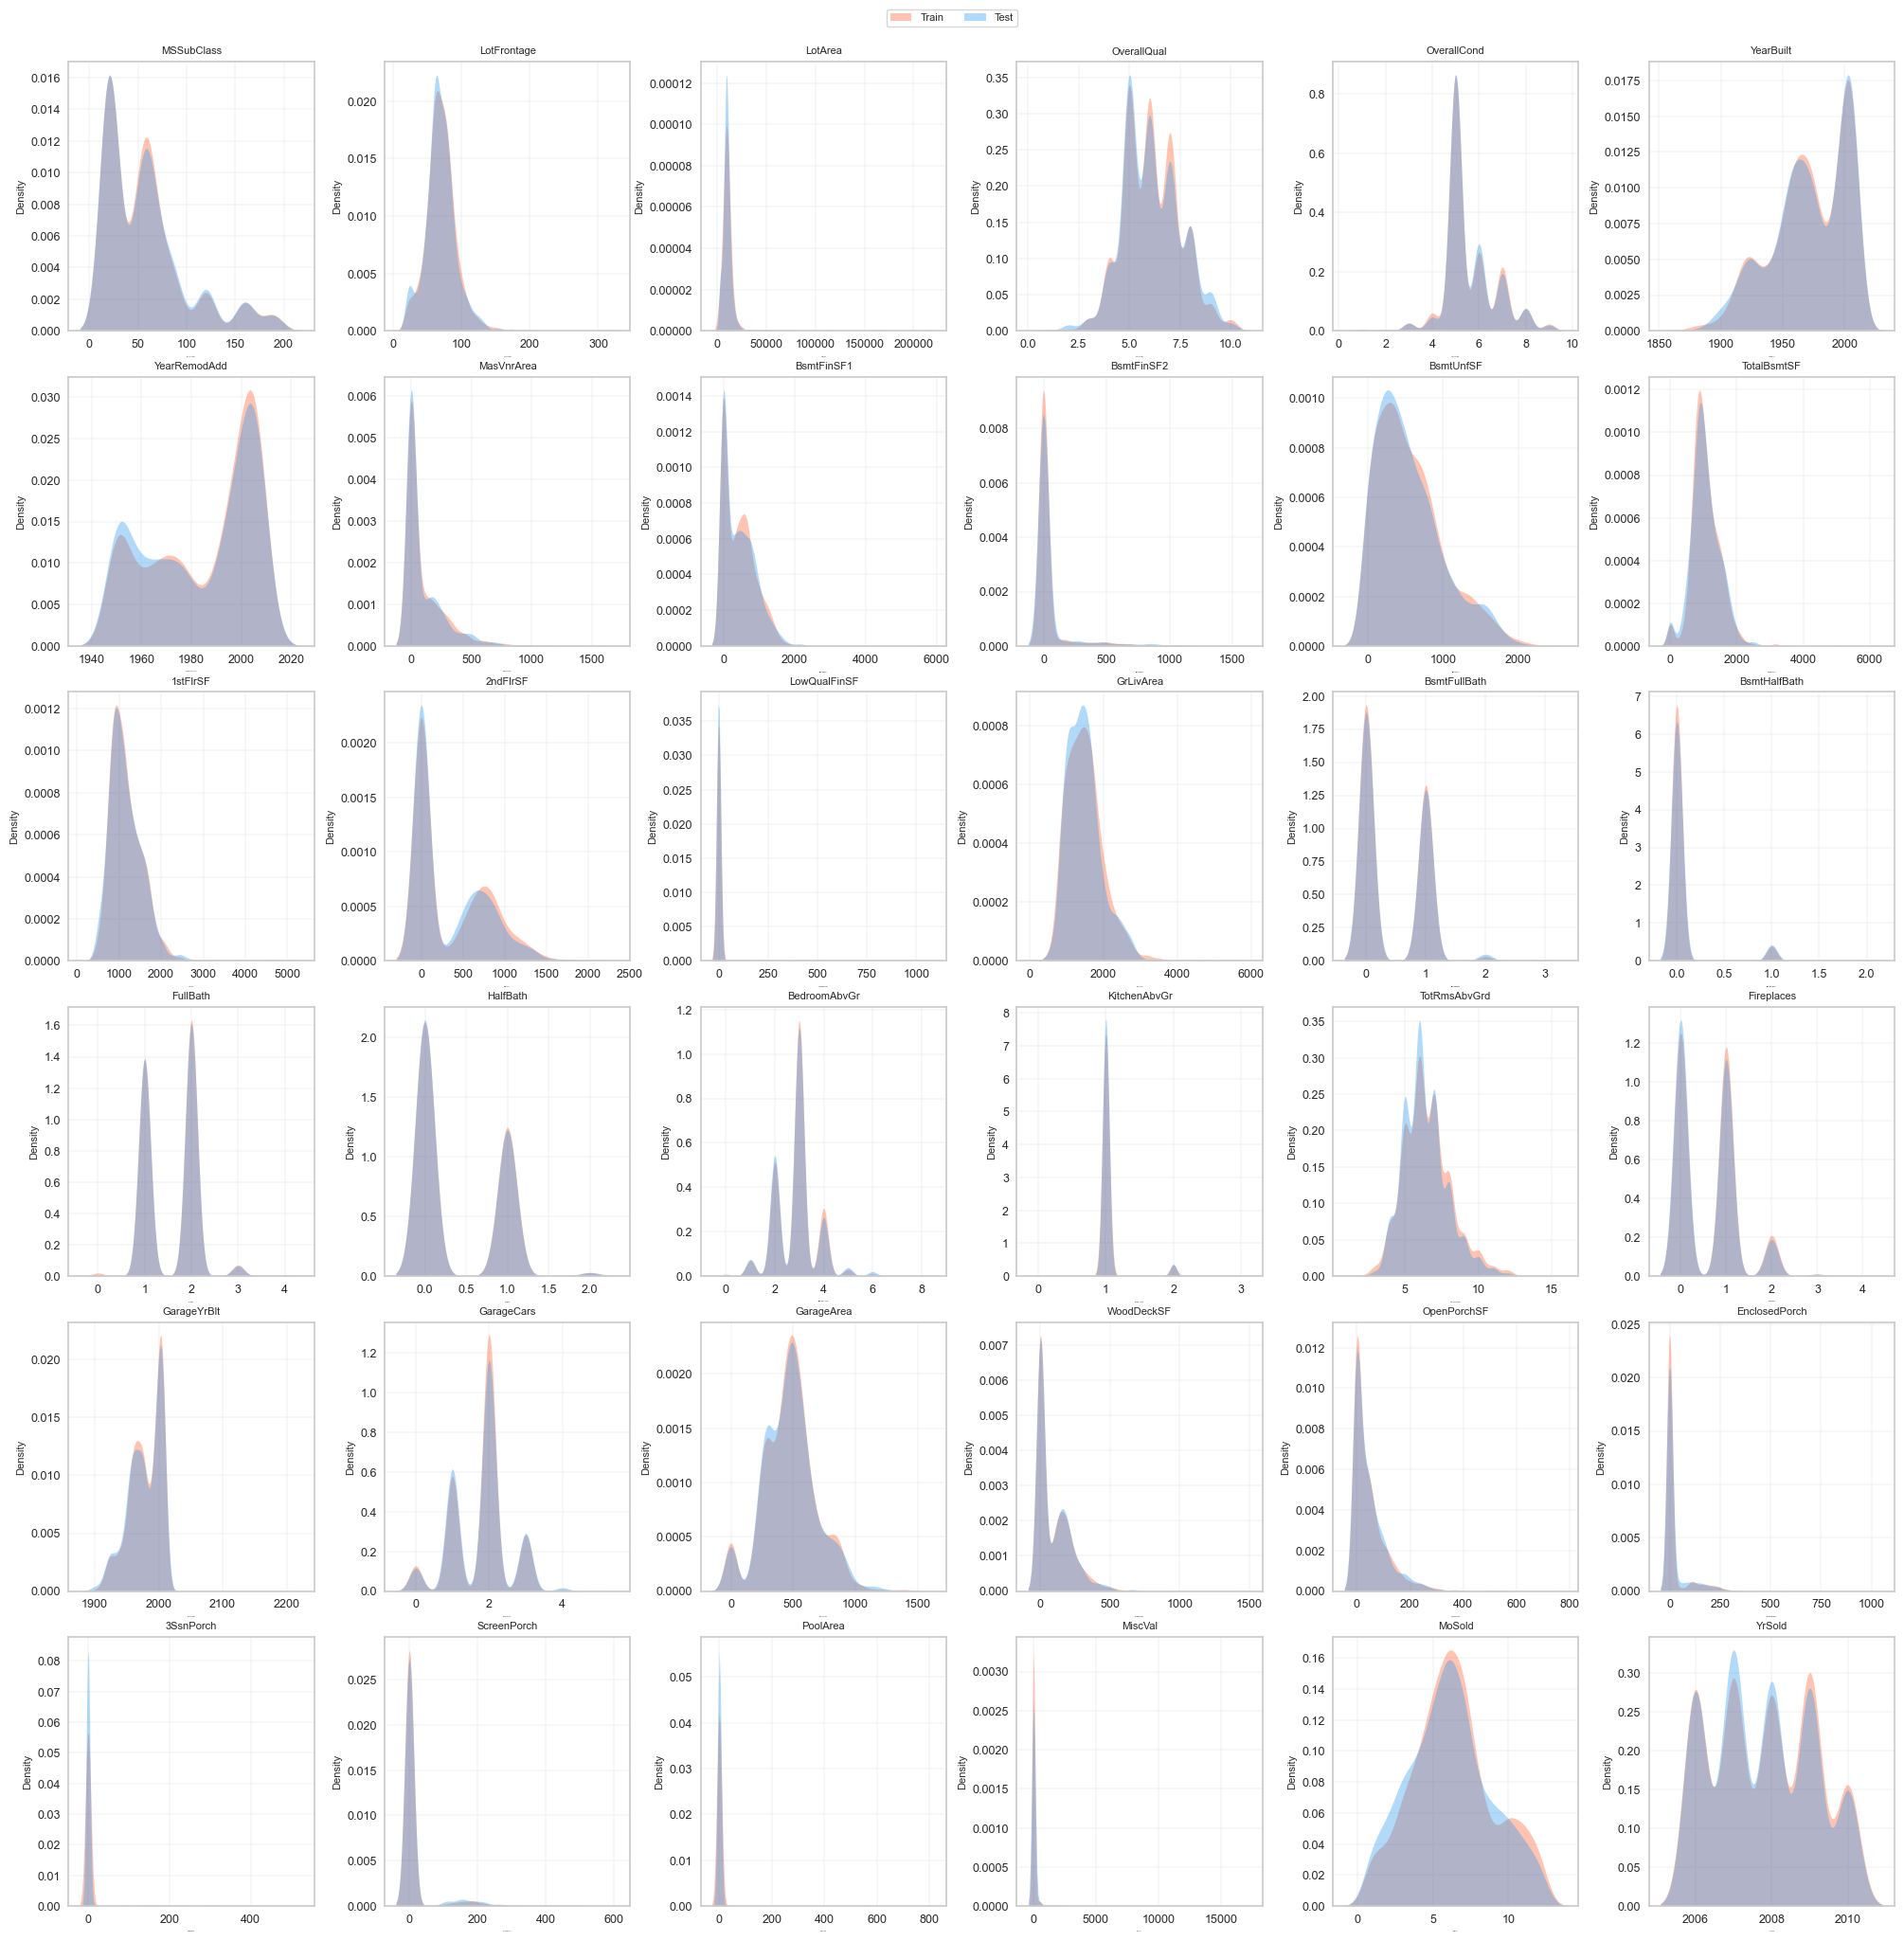

In [196]:
# Distribution of target and test datasets 

def plot_feature_distribution(df1, df2):
    plt.figure(figsize=(15,7))

    # Select only numerical features and remove 'Id' and 'SalePrice' columns
    df1_numerical = df1.select_dtypes(include=[np.number]).drop(['Id', 'SalePrice'], axis=1)
    df2_numerical = df2.select_dtypes(include=[np.number]).drop(['Id'], axis=1)
    features = pd.concat([df1_numerical, df2_numerical]).columns

    # Set Seaborn theme
    sns.set_theme(style="whitegrid", palette=[palette[1],palette[5]], font="sans-serif", font_scale=0.100, rc={'grid.color': '#d4d5d6', 'grid.linewidth': 0.25})
    
    # Calculate subplot dimensions
    num_features = len(features)
    num_columns = 6
    num_rows = (num_features + num_columns - 1) // num_columns

    # Create subplots
    fig, ax = plt.subplots(num_rows, num_columns, figsize=(20, 20), dpi = 100)

    for i, feature in enumerate(features):
        row, col = i // num_columns, i % num_columns
        ax[row, col].set_title(feature, fontsize=8)

        sns.kdeplot(data=df1_numerical, x=feature, fill=True, common_norm=False, linewidth=0, alpha=0.35, ax=ax[row, col])
        sns.kdeplot(data=df2_numerical, x=feature, fill=True, common_norm=False, linewidth=0, alpha=0.35, ax=ax[row, col])

        ax[row, col].set_ylabel("Density", fontsize=8)
        ax[row, col].tick_params(axis='both', which='major', labelsize=9, pad=0)

    # Hide empty subplots
    for i in range(num_features, num_rows * num_columns):
        fig.delaxes(ax.flatten()[i])

    # Add legend
    legends = ['Train', 'Test']
    plt.figlegend(legends, loc='upper center', ncol=5, labelspacing=0., fontsize=8, bbox_to_anchor=(0.5, 1.02))
    

    fig.tight_layout(pad=3.0)
    plt.show()

# Compare distribution in train and test sets
plot_feature_distribution(train, test)


*Based on the visual comparison of the distributions, there is no significant difference in the distribution of the target variable and the other features between the training and test sets. This is a positive aspect, as it means that the data in both sets is representative of the overall population. This will help ensure that our models generalise well to unseen data.*

**Dataset Overview Summary**:

Here's a summary of the key points about the dataset:

* The dataset is split evenly into a training and test set, with each set containing around 50% of the total records. This split ensures that we have a sufficient amount of data to train our models and evaluate their performance on unseen data.
* The dataset contains a total of 80 features and 1 target variable ('SalePrice'). These features encompass a wide range of attributes, including numerical, categorical, and ordinal variables, which will require different preprocessing techniques.
* All records in both the training and test sets have at least one feature value missing. This highlights the importance of handling missing data in our preprocessing steps, as it can impact the performance of our models.
* The dataset has no duplicate records. This is a positive aspect, as duplicate records can introduce bias and affect the generalization capabilities of our models.

In the upcoming sections, we will explore these features in greater detail, visualize their relationships with the target variable, and prepare the data for training our machine learning models.

# 2. Missing Values

**Understanding Missing Data** Let's take a closer look at the missing values in both the train and test datasets:

In [197]:
# Null Values Analysis

def null_features(df):
    # prep dataset EDA values
    summary = pd.DataFrame(df.dtypes,columns=['dtypes'])
    summary = summary.reset_index()
    summary['Name'] = summary['index']
    summary = summary[['Name','dtypes']]
    summary['Uniques'] = df.nunique().values
    summary['Null'] = df.isna().sum().values
    summary['Null(%)'] = round((summary['Null']  / len(df)*100),1).astype(str)+'%'

    # prep df
    summary = summary.sort_values(by=['Null', 'Name'], ascending=[False, True])
    summary.index = range(1, len(summary)+1)
    summary.drop(index=summary[summary['Null']==0].index, inplace=True)
    
    # return summary
    return summary


null_features(df)



Name   dtypes  Uniques  Null Null(%)
1         PoolQC   object        3  2909   99.7%
2    MiscFeature   object        4  2814   96.4%
3          Alley   object        2  2721   93.2%
4          Fence   object        4  2348   80.4%
5      SalePrice  float64      663  1459   50.0%
6    FireplaceQu   object        5  1420   48.6%
7    LotFrontage  float64      128   486   16.6%
8     GarageCond   object        5   159    5.4%
9   GarageFinish   object        3   159    5.4%
10    GarageQual   object        5   159    5.4%
11   GarageYrBlt  float64      103   159    5.4%
12    GarageType   object        6   157    5.4%
13      BsmtCond   object        4    82    2.8%
14  BsmtExposure   object        4    82    2.8%
15      BsmtQual   object        4    81    2.8%
16  BsmtFinType2   object        6    80    2.7%
17  BsmtFinType1   object        6    79    2.7%
18    MasVnrType   object        4    24    0.8%
19    MasVnrArea  float64      444    23    0.8%
20      MSZoning   object        5     4    0.1%
21  BsmtFullBath  float64        4     2    0.1%
22  BsmtHalfBath  float64        3     2    0.1%
23    Functional   object        7     2    0.1%
24     Utilities   object        2     2    0.1%
25    BsmtFinSF1  float64      991     1    0.0%
26    BsmtFinSF2  float64      272     1    0.0%
27     BsmtUnfSF  float64     1135     1    0.0%
28    Electrical   object        5     1    0.0%
29   Exterior1st   object       15     1    0.0%
30   Exterior2nd   object       16     1    0.0%
31    GarageArea  float64      603     1    0.0%
32    GarageCars  float64        6     1    0.0%
33   KitchenQual   object        4     1    0.0%
34      SaleType   object        9     1    0.0%
35   TotalBsmtSF  float64     1058     1    0.0%

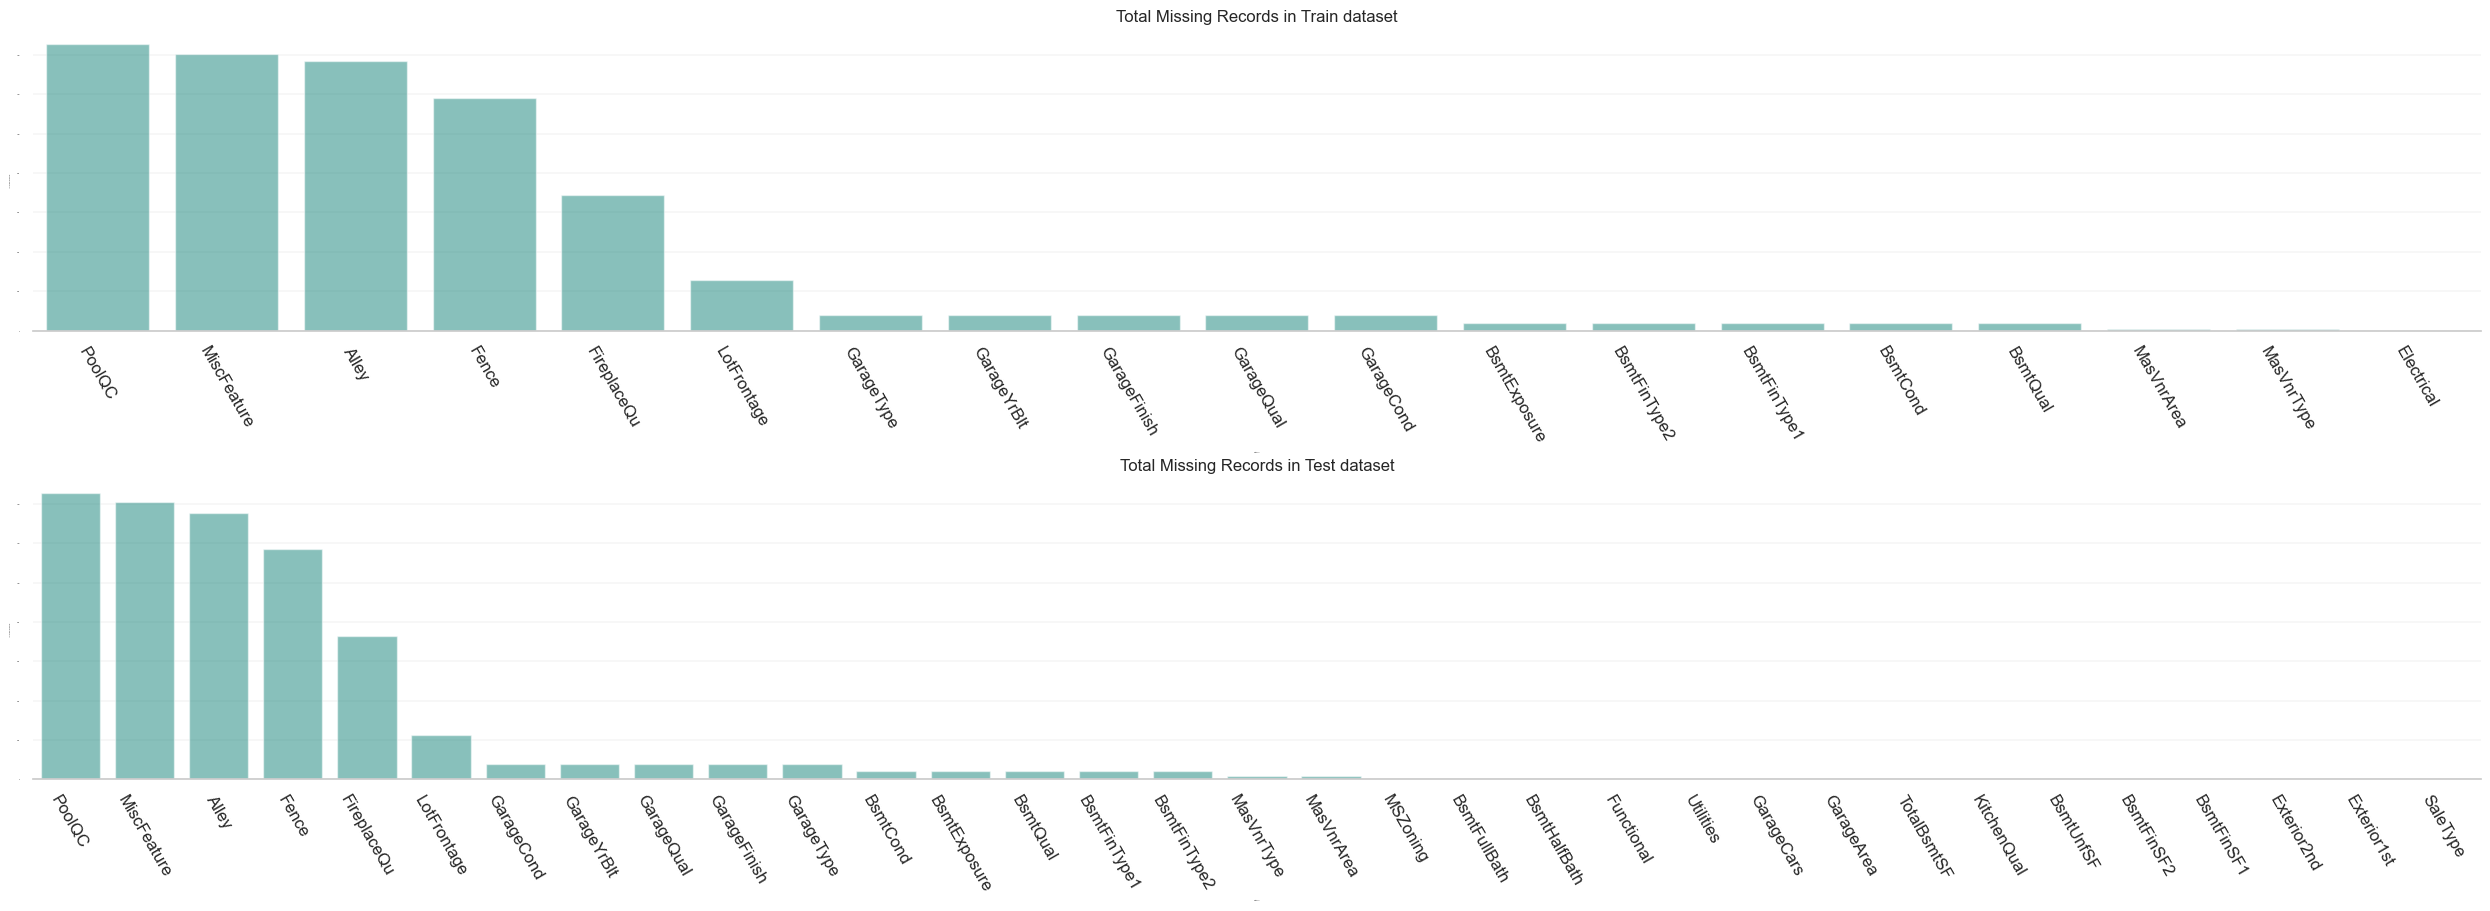

In [198]:
# Plot Null Values in train and test datasets
def null_features_eda(df1, df2, name1, name2):
    
    features_w_na1 = df1.columns[df1.isna().any()]
    features_w_na_plot1 = df1[features_w_na1].isnull().sum().sort_values(ascending=False)
    
    features_w_na2 = df2.columns[df2.isna().any()]
    features_w_na_plot2 = df2[features_w_na2].isnull().sum().sort_values(ascending=False)
    
    
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(25, 8), dpi=100)
    sns.set_theme(style="whitegrid", palette="husl", rc={'grid.color': '#d4d5d6', 'grid.linewidth': 0.25})
    
    sns.barplot(x=features_w_na_plot1.index, y=features_w_na_plot1, palette=palette[0:1], alpha=alpha, ax=ax1)
    sns.barplot(x=features_w_na_plot2.index, y=features_w_na_plot2, palette=palette[0:1], alpha=alpha, ax=ax2)
    plt.tight_layout(h_pad=8)
    # Customize plots
    for ax, name, features_w_na_plot in zip([ax1, ax2], [name1, name2], [features_w_na_plot1, features_w_na_plot2]):
        sns.despine(top=True, right=True, left=True, bottom=False, ax=ax)
        ax.set_xticklabels(ax.get_xticklabels(), rotation=300, fontsize=12, ha='center')
        ax.set_xlabel('Features')
        ax.set_ylabel('(%) of Null Records')
        ax.set_title(f'Total Missing Records in {name} dataset')
        

# Display side by side bar plots
null_features_eda(train, test, 'Train', 'Test')


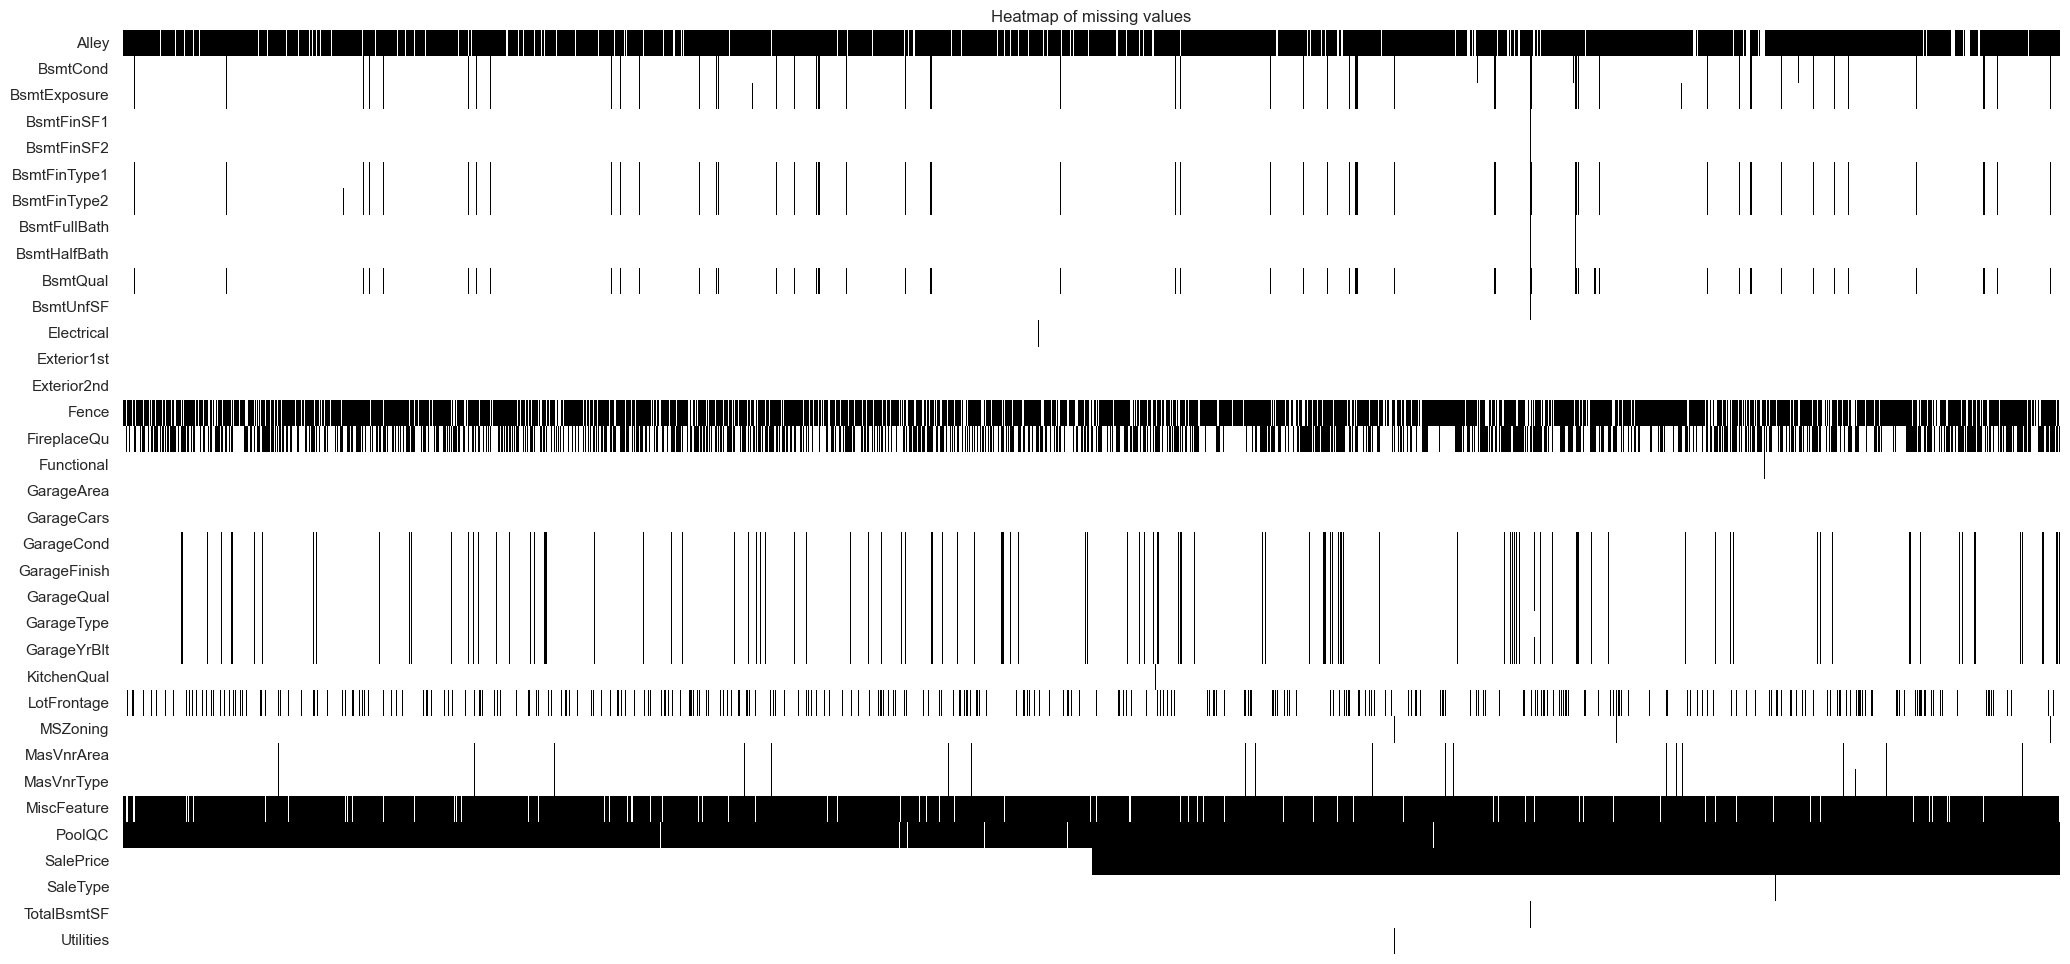

In [199]:
# Heatmap of missing values
na_cols=df.columns[df.isna().any()].sort_values().tolist()


plt.figure(figsize=(25,12), dpi = 100)
sns.heatmap((df[na_cols].isna()).T, cmap='gray_r', cbar=False, yticklabels=True, xticklabels=False)
plt.title('Heatmap of missing values')
plt.show()

We can observe that the missing features are completely at random (**MCAR**). This means that the missing values are not related to the target variable or any other feature in the dataset. This is a positive aspect, as it means that we can use simple imputation techniques to fill in the missing values. 

* Some features have a very high percentage of missing values (e.g., PoolQC, MiscFeature, Alley, and Fence). We will use a simple imputation technique (0 or 'None') to fill in the missing values for these features.
* The Garage related features have a similar number of missing values. This indicates that the missing values are likely to be related to the same records. However, the most important aspect of a garage is the number of cars it can fit, which is captured by the GarageCars feature, and the area of the garage, which is captured by the GarageArea feature. Therefore, we will focus on these two features and drop the rest of the Garage related features.
* The Basement related features have a similar number of missing values. This indicates that the missing values are likely to be related to the same records. However, the most important aspect of a basement is the area of the basement, which is captured by the TotalBsmtSF feature and the number of bathrooms in the basement, which is captured by the BsmtFullBath and BsmtHalfBath features. Therefore, we will focus on these two features and drop the rest of the Basement related features.
* we will investigate the rest of the features with missing values and decide whether to drop them or impute them.

## Handelling Missing Values

In [200]:
# # drop columns with high rate of missing values
# df.drop(columns=['Alley', 'FireplaceQu', 'PoolQC', 'Fence', 'MiscFeature'], inplace=True)
# train.drop(columns=['Alley', 'FireplaceQu', 'PoolQC', 'Fence', 'MiscFeature'], inplace=True)
# test.drop(columns=['Alley', 'FireplaceQu', 'PoolQC', 'Fence', 'MiscFeature'], inplace=True)

In [201]:
# # drop features garage features except GarageCars and GarageArea
# df.drop(columns=['GarageYrBlt', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond'], inplace=True)
# train.drop(columns=['GarageYrBlt', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond'], inplace=True)
# test.drop(columns=['GarageYrBlt', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond'], inplace=True)

In [202]:
# # drop features basement features except TotalBsmtSF and BsmtFullBath and BsmtHalfBath
# df.drop(columns=['BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'], inplace=True)
# train.drop(columns=['BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'], inplace=True)
# test.drop(columns=['BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'], inplace=True)

**LotFrontage**: *Linear feet of street connected to property*


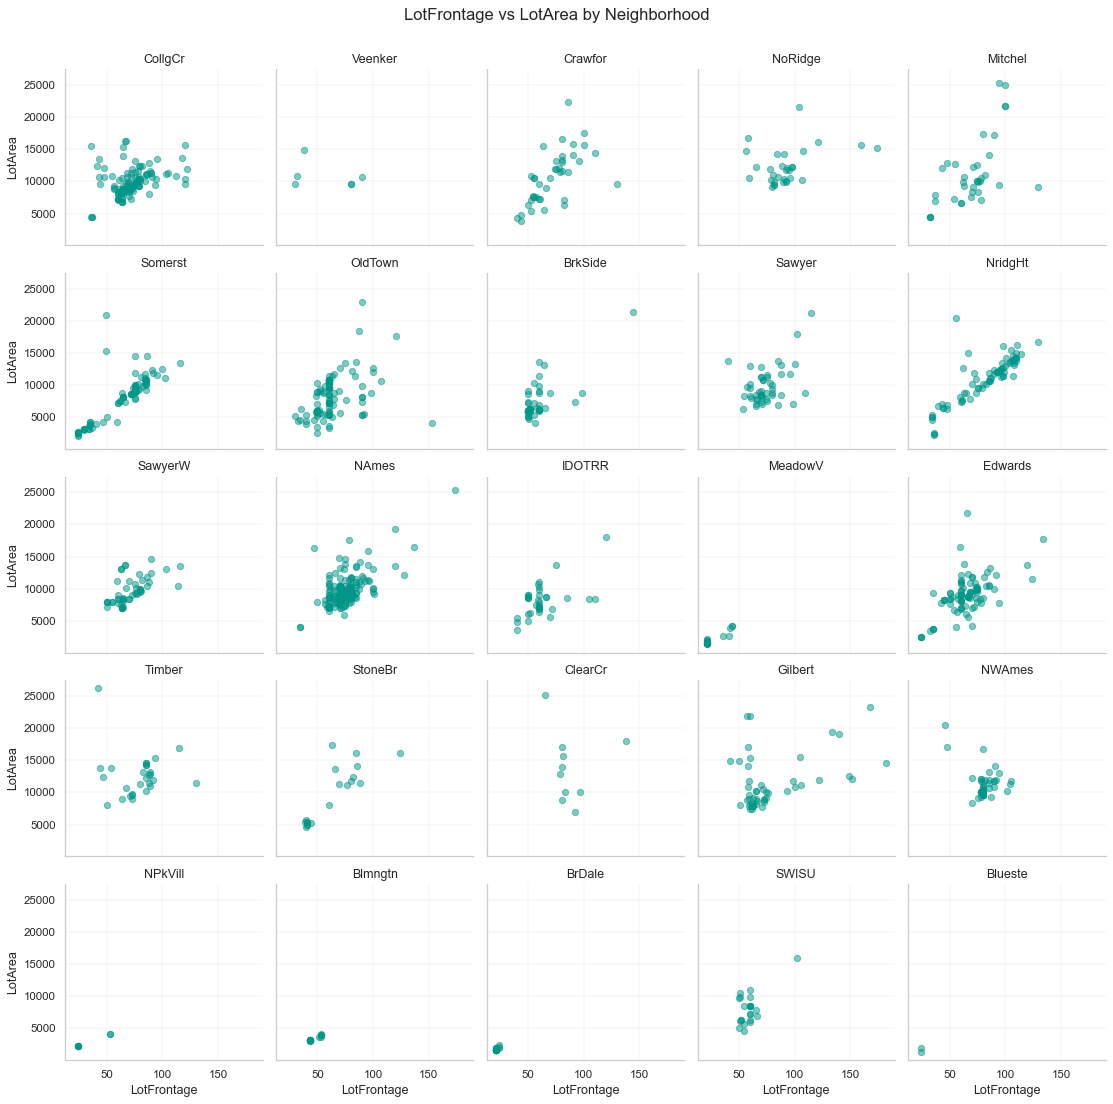

In [203]:
# LotFrontage vs LotArea by Neighborhood
g = sns.FacetGrid(train[(train['LotArea'] < 30000) & (train['LotFrontage'] < 250)], col='Neighborhood', col_wrap=5)


def scatter_func(x, y, color, **kwargs):
    plt.scatter(x, y, color=color, alpha = alpha, **kwargs)
     

g.map(scatter_func, 'LotFrontage', 'LotArea', color=palette[0]) 
g.set_axis_labels('LotFrontage', 'LotArea') 
g.set_titles('{col_name}')
g.fig.subplots_adjust(top=0.925)
g.fig.suptitle('LotFrontage vs LotArea by Neighborhood', fontsize=16)

plt.show()

there seems to be a correlation between '**LotFrontage**' and '**LotArea**' by **Neighborhood**. Using KNN imputation to fill in missing values for 'LotFrontage' can be a more accurate approach in this case. 

KNN imputation estimates the missing values by finding the k-nearest neighbors to the observation with missing data and taking the average of their non-missing values. By considering both 'LotArea' and 'Neighborhood', we can leverage the spatial relationship between houses and their lot sizes to better estimate the missing 'LotFrontage' values.

In [204]:
# Use KNNImputer to impute missing values in LotFrontage
def LotFrontage_KNN_Imputer(data, n_neighbors=5):
    df_KNN_imp = data[['Neighborhood', 'LotFrontage', 'LotArea']].copy()

    df_KNN_imp = pd.get_dummies(df_KNN_imp, columns=['Neighborhood'], drop_first=False)

    imputer = KNNImputer(n_neighbors=n_neighbors)
    df_KNN_imp['LotFrontage'] = imputer.fit_transform(df_KNN_imp)

    # Merge imputed values back into the original data
    data['LotFrontage'] = df_KNN_imp['LotFrontage']
    
    return data

# Example usage
df = LotFrontage_KNN_Imputer(df)


train = LotFrontage_KNN_Imputer(train)
test = LotFrontage_KNN_Imputer(test)

**Mising Values** 

For the remaining features with a small number of missing values, we can use a simple yet effective imputation technique to fill in the gaps. In this case, we'll impute the missing values with the median value for numerical features (as it's less sensitive than the mean) and the most frequent value for categorical features (mode) of the corresponding feature in the training set. 


In [205]:
# replace missing values in the following features with 'None' 
none_features = [
    'Alley', 'PoolQC', 'MiscFeature', 'Fence', 'FireplaceQu', 'GarageType',
    'GarageFinish', 'GarageQual', 'GarageCond', 'BsmtQual', 'BsmtCond',
    'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'MasVnrType'
]

df = df.fillna({col: 'None' for col in none_features})
train = train.fillna({col: 'None' for col in none_features})
test = test.fillna({col: 'None' for col in none_features})

In [206]:
# Ensure there are no Garage details if GarageYrBlt is missing
df.loc[df['GarageYrBlt'].isna(), ['GarageType', 'GarageCond', 'GarageFinish', 'GarageQual']] = 'None'
train.loc[train['GarageYrBlt'].isna(), ['GarageType', 'GarageCond', 'GarageFinish', 'GarageQual']] = 'None'
test.loc[test['GarageYrBlt'].isna(), ['GarageType', 'GarageCond', 'GarageFinish', 'GarageQual']] = 'None'


In [207]:
# Impute missing values in all other features
def impute_numerical(data, strategy='constant', fill_value=0):
    imputer = SimpleImputer(strategy=strategy)
    imputer.fit(data)
    return imputer

def impute_categorical(data, strategy='most_frequent'):
    imputer = SimpleImputer(strategy=strategy)
    imputer.fit(data)
    return imputer

null = null_features(df.drop(columns=['SalePrice']))

# Impute numerical columns
num_cols = null[null['dtypes'] == 'float64']['Name'].tolist()
num_imputer = impute_numerical(train[num_cols])
train[num_cols] = num_imputer.transform(train[num_cols])
test[num_cols] = num_imputer.transform(test[num_cols])
df[num_cols] = num_imputer.transform(df[num_cols])

# Impute categorical columns
cat_cols = null[null['dtypes'] != 'float64']['Name'].tolist()
cat_imputer = impute_categorical(train[cat_cols])
train[cat_cols] = cat_imputer.transform(train[cat_cols])
test[cat_cols] = cat_imputer.transform(test[cat_cols])
df[cat_cols] = cat_imputer.transform(df[cat_cols])

# EDA

**Sale Price**: Target variable

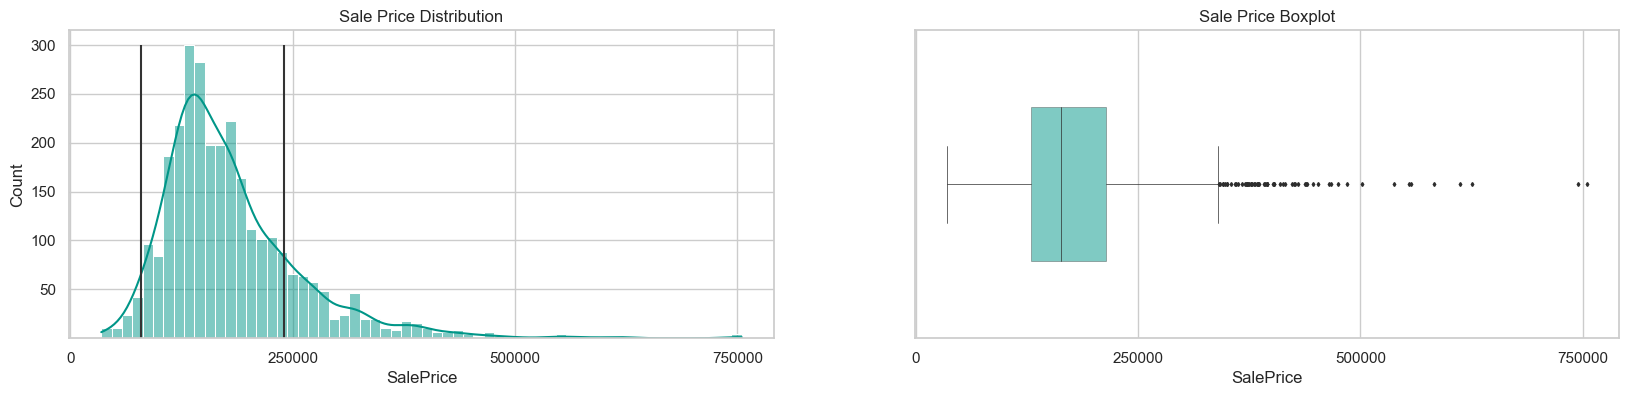

Sale Price skewness: 1.883
Sale Price kurtosis: 6.536


In [208]:
# plot Target variable

# Set the theme for the figures
sns.set_theme(style="whitegrid")

# Set the figure size, and create 1 row and 2 columns of subplots
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20, 4), dpi=100)
x_axis = [0, 250000, 500000, 750000]

# Histogram
sns.histplot(data=df, x='SalePrice', 
             kde=True, 
             ax=ax1, 
             color=palette[0], 
             alpha=alpha)

ax1.set_title('Sale Price Distribution')
ax1.set_yticks([50, 100, 150, 200, 250, 300])
ax1.set_xticks(x_axis)
ax1.vlines(80000, ymin=0, ymax=300, color='#333333')
ax1.vlines(240000, ymin=0, ymax=300, color='#333333')

# Boxplot SalePrice
sns.boxplot(x=train["SalePrice"], 
            ax=ax2, 
            color=palette[0], 
            width=0.5, 
            linewidth=0.5, 
            fliersize=2, 
            saturation=1, 
            boxprops=dict(alpha=alpha), 
            palette =palette[0:1])
ax2.set_title('Sale Price Boxplot')
ax2.set_xticks(x_axis)

plt.show()

# distribution measures
print("Sale Price skewness: {:.3f}".format(train["SalePrice"].skew()))
print("Sale Price kurtosis: {:.3f}".format(train["SalePrice"].kurtosis()))

**distribution measures**
* **Skewness** measures the asymmetry of the probability distribution of a real-valued random variable about its mean. In simpler terms, it tells you how much a distribution is shifted or "skewed" to the left or right. A skewness value of 0 indicates a perfectly symmetrical distribution.
* **Kurtosis** measures the "tailedness" of the probability distribution of a real-valued random variable. It describes how heavy the tails of the distribution are compared to a normal distribution. Higher kurtosis values indicate that the distribution has heavier tails and a sharper peak, while lower kurtosis values indicate lighter tails and a flatter peak.

The Sale Price kurtosis is 6.536. Since a normal distribution has a kurtosis value of 3, this higher value indicates that the Sale Price distribution has heavier tails and a more peaked center than a normal distribution as can be seen in the distribution above.

**Target Variable Summary**:

Our target variable for this problem is the **Sale Price** of houses. Let's summarize the key insights about this variable:

* There are no records with less than zero. This is expected, as house prices should always be positive.
* The House Sale Price variable is not normally distributed. This is important because certain machine learning algorithms assume that the input data is normally distributed.
* The dataset has a lot of extreme values (outliers) and a very sharp peak. Outliers can significantly impact the performance of our models, so we'll need to address them during preprocessing.
* The distribution of house prices exhibits positive (right-skewed) skewness. This means that the majority of the houses are priced lower than the average, with a few houses having significantly higher prices (outliers). 
* The peakedness of the distribution lies between 80,000 and 240,000. This indicates that the majority of the houses fall within this price range.

As we proceed with our analysis, we will keep these characteristics in mind to ensure that our models are able to make accurate predictions. We may need to apply data transformations or outlier removal techniques to better fit the assumptions of our chosen machine learning algorithms.

<Figure size 480x360 with 0 Axes>

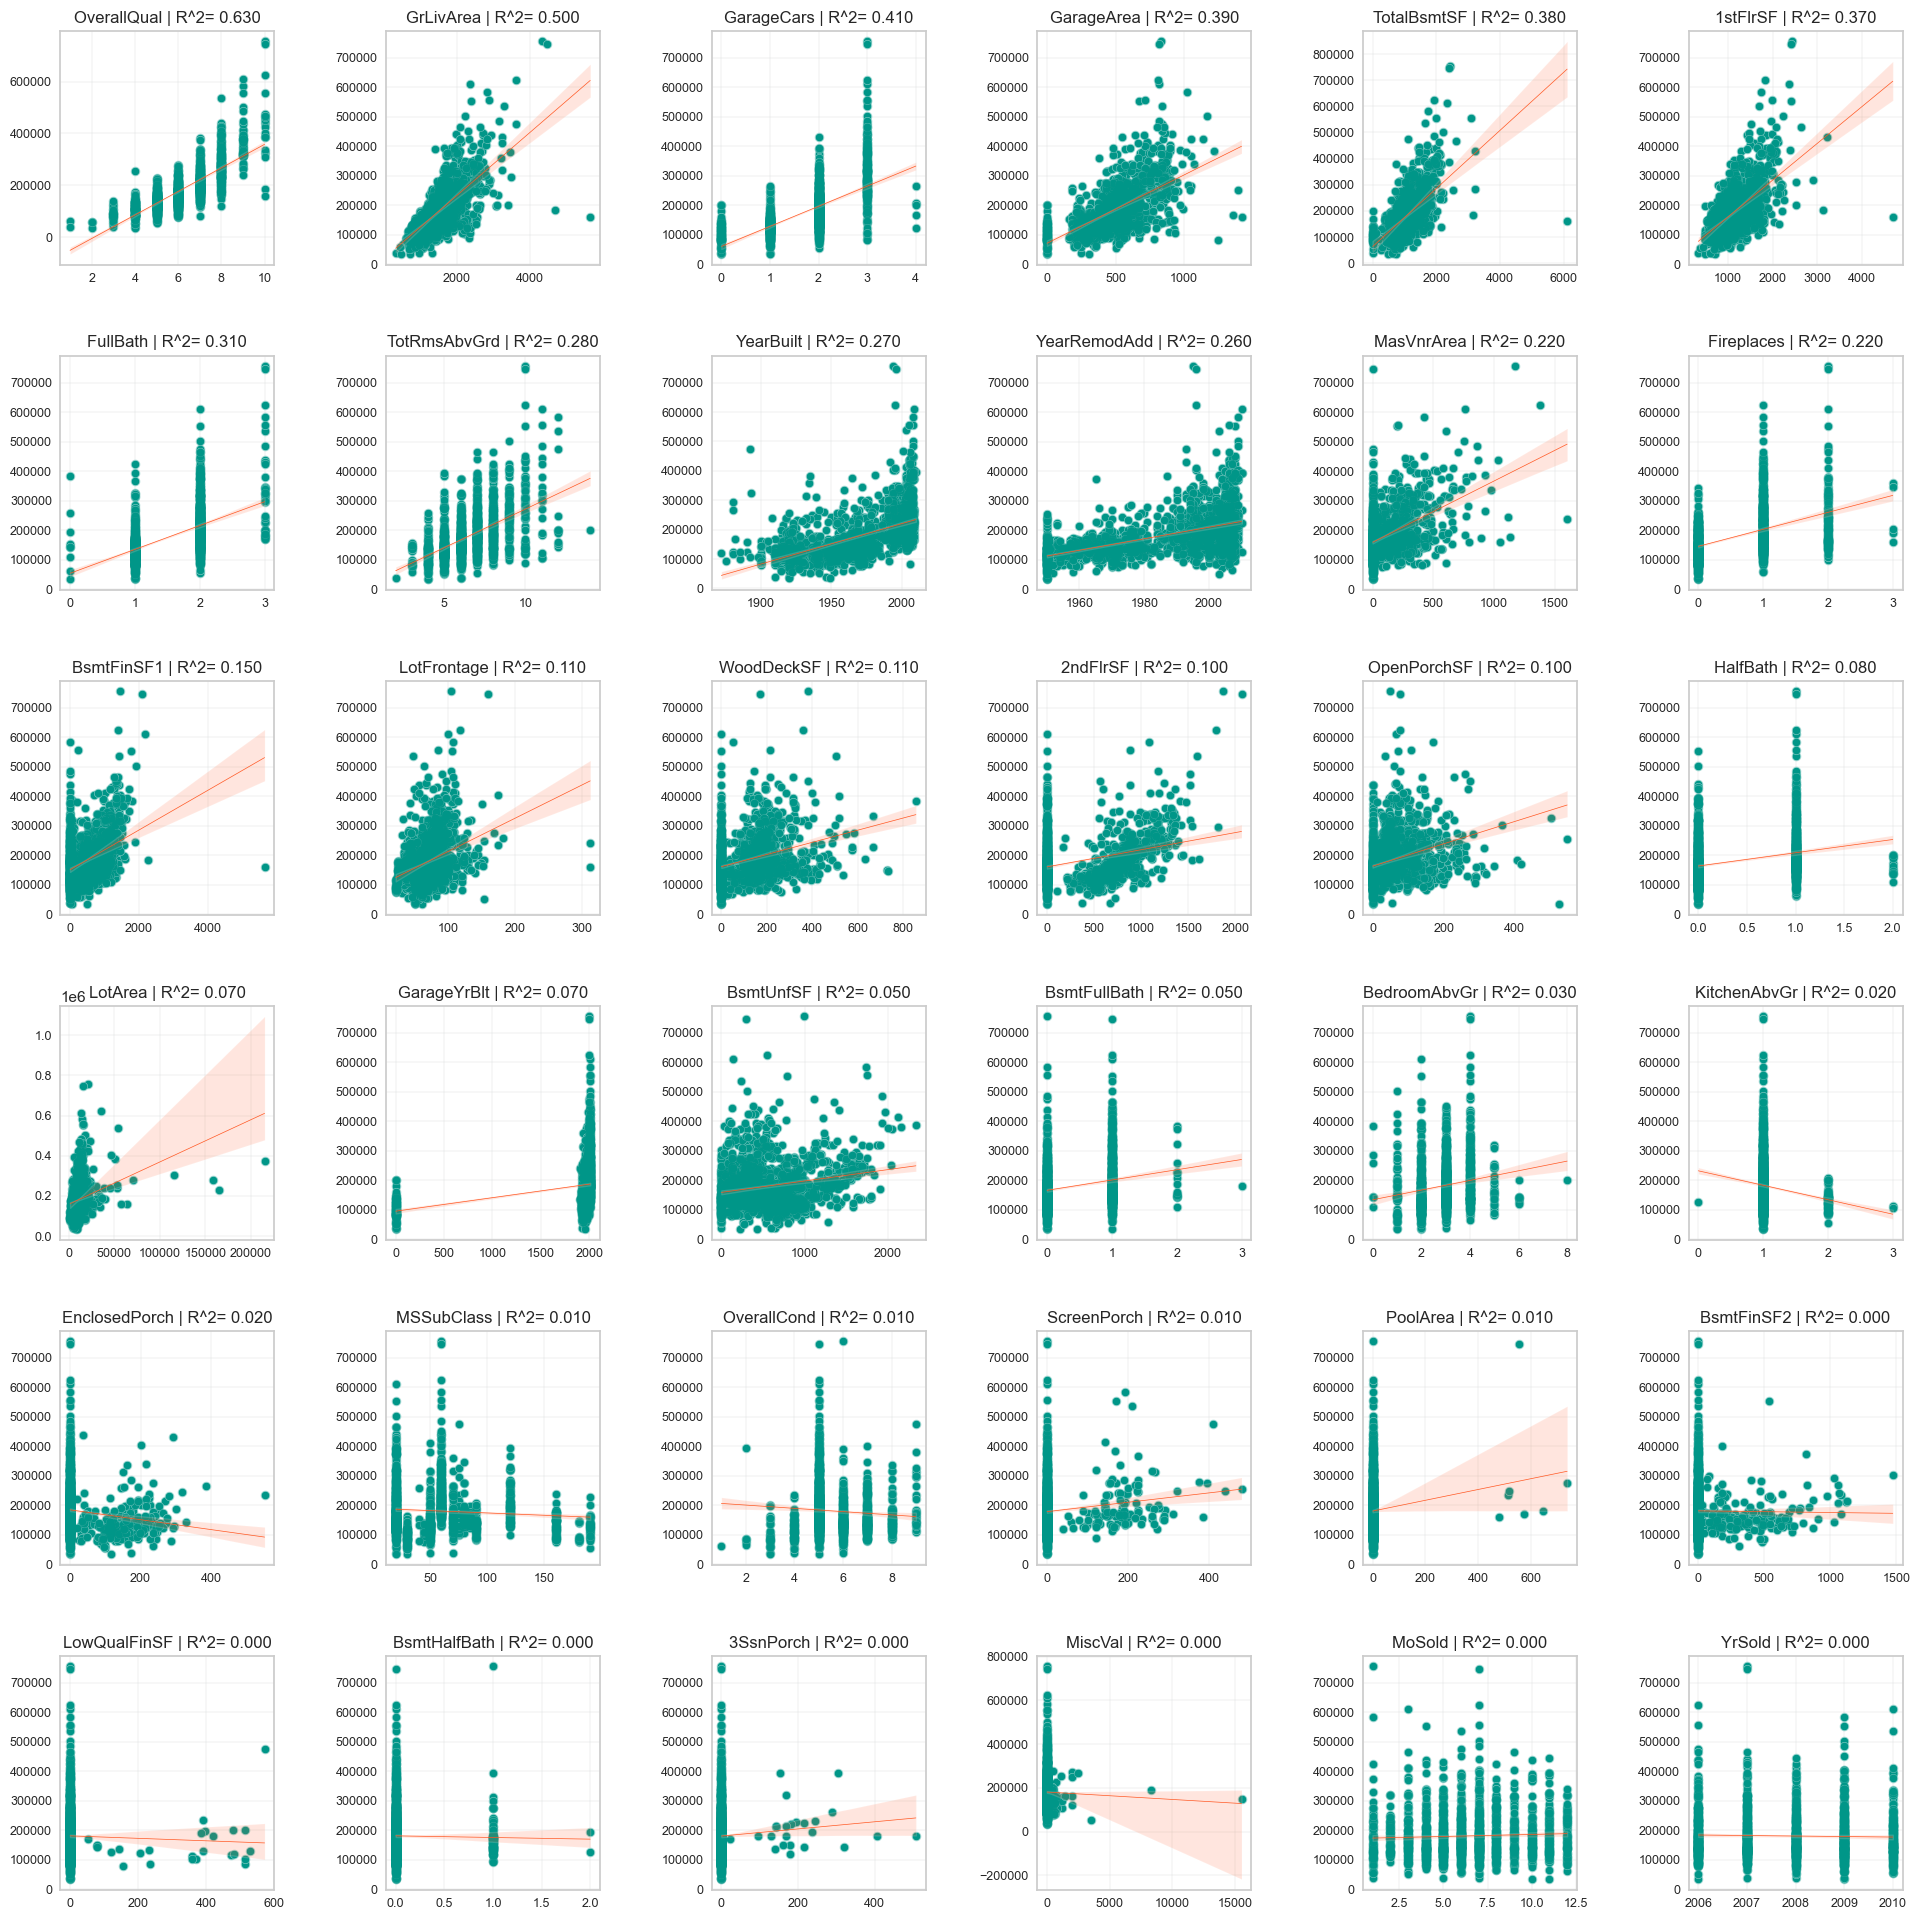

In [209]:
# plot all features in test set with scatterplot
def scatterplot_target(df,row,col,h,w): 
    i = 0
    temp = df.select_dtypes(include=[np.number]).drop(['Id'], axis=1)
    features = df.select_dtypes(include=[np.number]).drop(['Id','SalePrice'], axis=1).columns
    

    r2 = [{'Feature': feature, 'R^2': np.NaN} for feature in features]

    for i, feature in enumerate(features):
        corr, _ = scipy.stats.pearsonr(temp[feature].loc[temp[feature].notna()], df['SalePrice'].loc[temp[feature].notna()])
        r2[i]['R^2'] = round(corr**2,2)
        
    r2_sorted = sorted(r2, key=lambda x: x['R^2'], reverse=True)
    features = [d['Feature'] for d in r2_sorted]
    
    i = 0    
    # set theme
    sns.set_theme(style="whitegrid", palette=palette[0:1], rc={'grid.color': '#d4d5d6', 'grid.linewidth': 0.25})
    plt.figure()
    fig, ax = plt.subplots(row,col,figsize=(h,w), dpi=100)

    for feature in features:
        i += 1
        corr, _ = scipy.stats.pearsonr(temp[feature].loc[temp[feature].notna()], df['SalePrice'].loc[temp[feature].notna()])
        r2 = round(corr**2,2)
        plt.subplot(row,col,i)
        sns.scatterplot(data = temp, x = feature, y='SalePrice')
        
        sns.regplot(data=temp, x=feature, y='SalePrice', 
                    scatter_kws={"color": palette[0], 'alpha': alpha*0.5}, 
                    line_kws={"color": palette[1], "linewidth": 0.5})
        
        # add R^2 score to labels 
        subheader = "{} | R^2= {:.3f}".format(feature, r2)
        plt.title(subheader, fontsize=12)
        locs, labels = plt.xticks()
        plt.tick_params(axis='x', which='major', labelsize=9, pad = 0)
        plt.tick_params(axis='y', which='major', labelsize=9, pad = 0)
        plt.ylabel("",fontsize=0)
        plt.xlabel("",fontsize=0)
    fig.tight_layout(pad=3.0)
    plt.show()
    
scatterplot_target(train,6,6,20,20)

Looking at the entire dataset, we can see that there are number of features that are highly correlated with the target variable. These features are likely to be important predictors of the target variable and will be useful for our machine learning models. We will explore these features in greater detail. In addition, we can observe that some numerical features are categorical (e.g. MSSubClass, Month sold), converting these features to their correct data type can help ensure that our models treat them appropriately. 

In [210]:
# convert MSSubClass to categorical
df['MSSubClass'] = 'SC'+df['MSSubClass'].astype(str)
train['MSSubClass'] = 'SC'+train['MSSubClass'].astype(str)
test['MSSubClass'] = 'SC'+test['MSSubClass'].astype(str)

**BedroomsAbvGr**: *Number of bedrooms above basement level* 

Seems like there are some houses with 0 bedrooms above ground. This is likely an error in the data. We will use the median value of the 'GrLivArea' feature to impute the missing values.

In [211]:
# Calculate the median of GrLivArea per bedroom for non-zero BedroomAbvGr values based on the Median of GrLivArea per bedroom for non-zero BedroomAbvGr values in the training set
def update_zero_bedrooms(dataframe):
    # Calculate the median of GrLivArea per bedroom for non-zero BedroomAbvGr values
    median_GrLivArea_per_bedroom = train[train['BedroomAbvGr'] != 0].groupby('BedroomAbvGr')['GrLivArea'].median()

    # Select the rows with BedroomAbvGr equal to 0
    rows_with_zero_bedrooms = dataframe[dataframe['BedroomAbvGr'] == 0][['BedroomAbvGr', 'GrLivArea']]

    # Find the closest BedroomAbvGr value based on GrLivArea for each row with zero bedrooms
    for index, row in rows_with_zero_bedrooms.iterrows():
        closest_bedroom = median_GrLivArea_per_bedroom.index[np.abs(median_GrLivArea_per_bedroom - row['GrLivArea']).argmin()]
        dataframe.loc[index, 'BedroomAbvGr'] = closest_bedroom
        
# Apply the function to the training and test sets
update_zero_bedrooms(df)
update_zero_bedrooms(train)
update_zero_bedrooms(test)


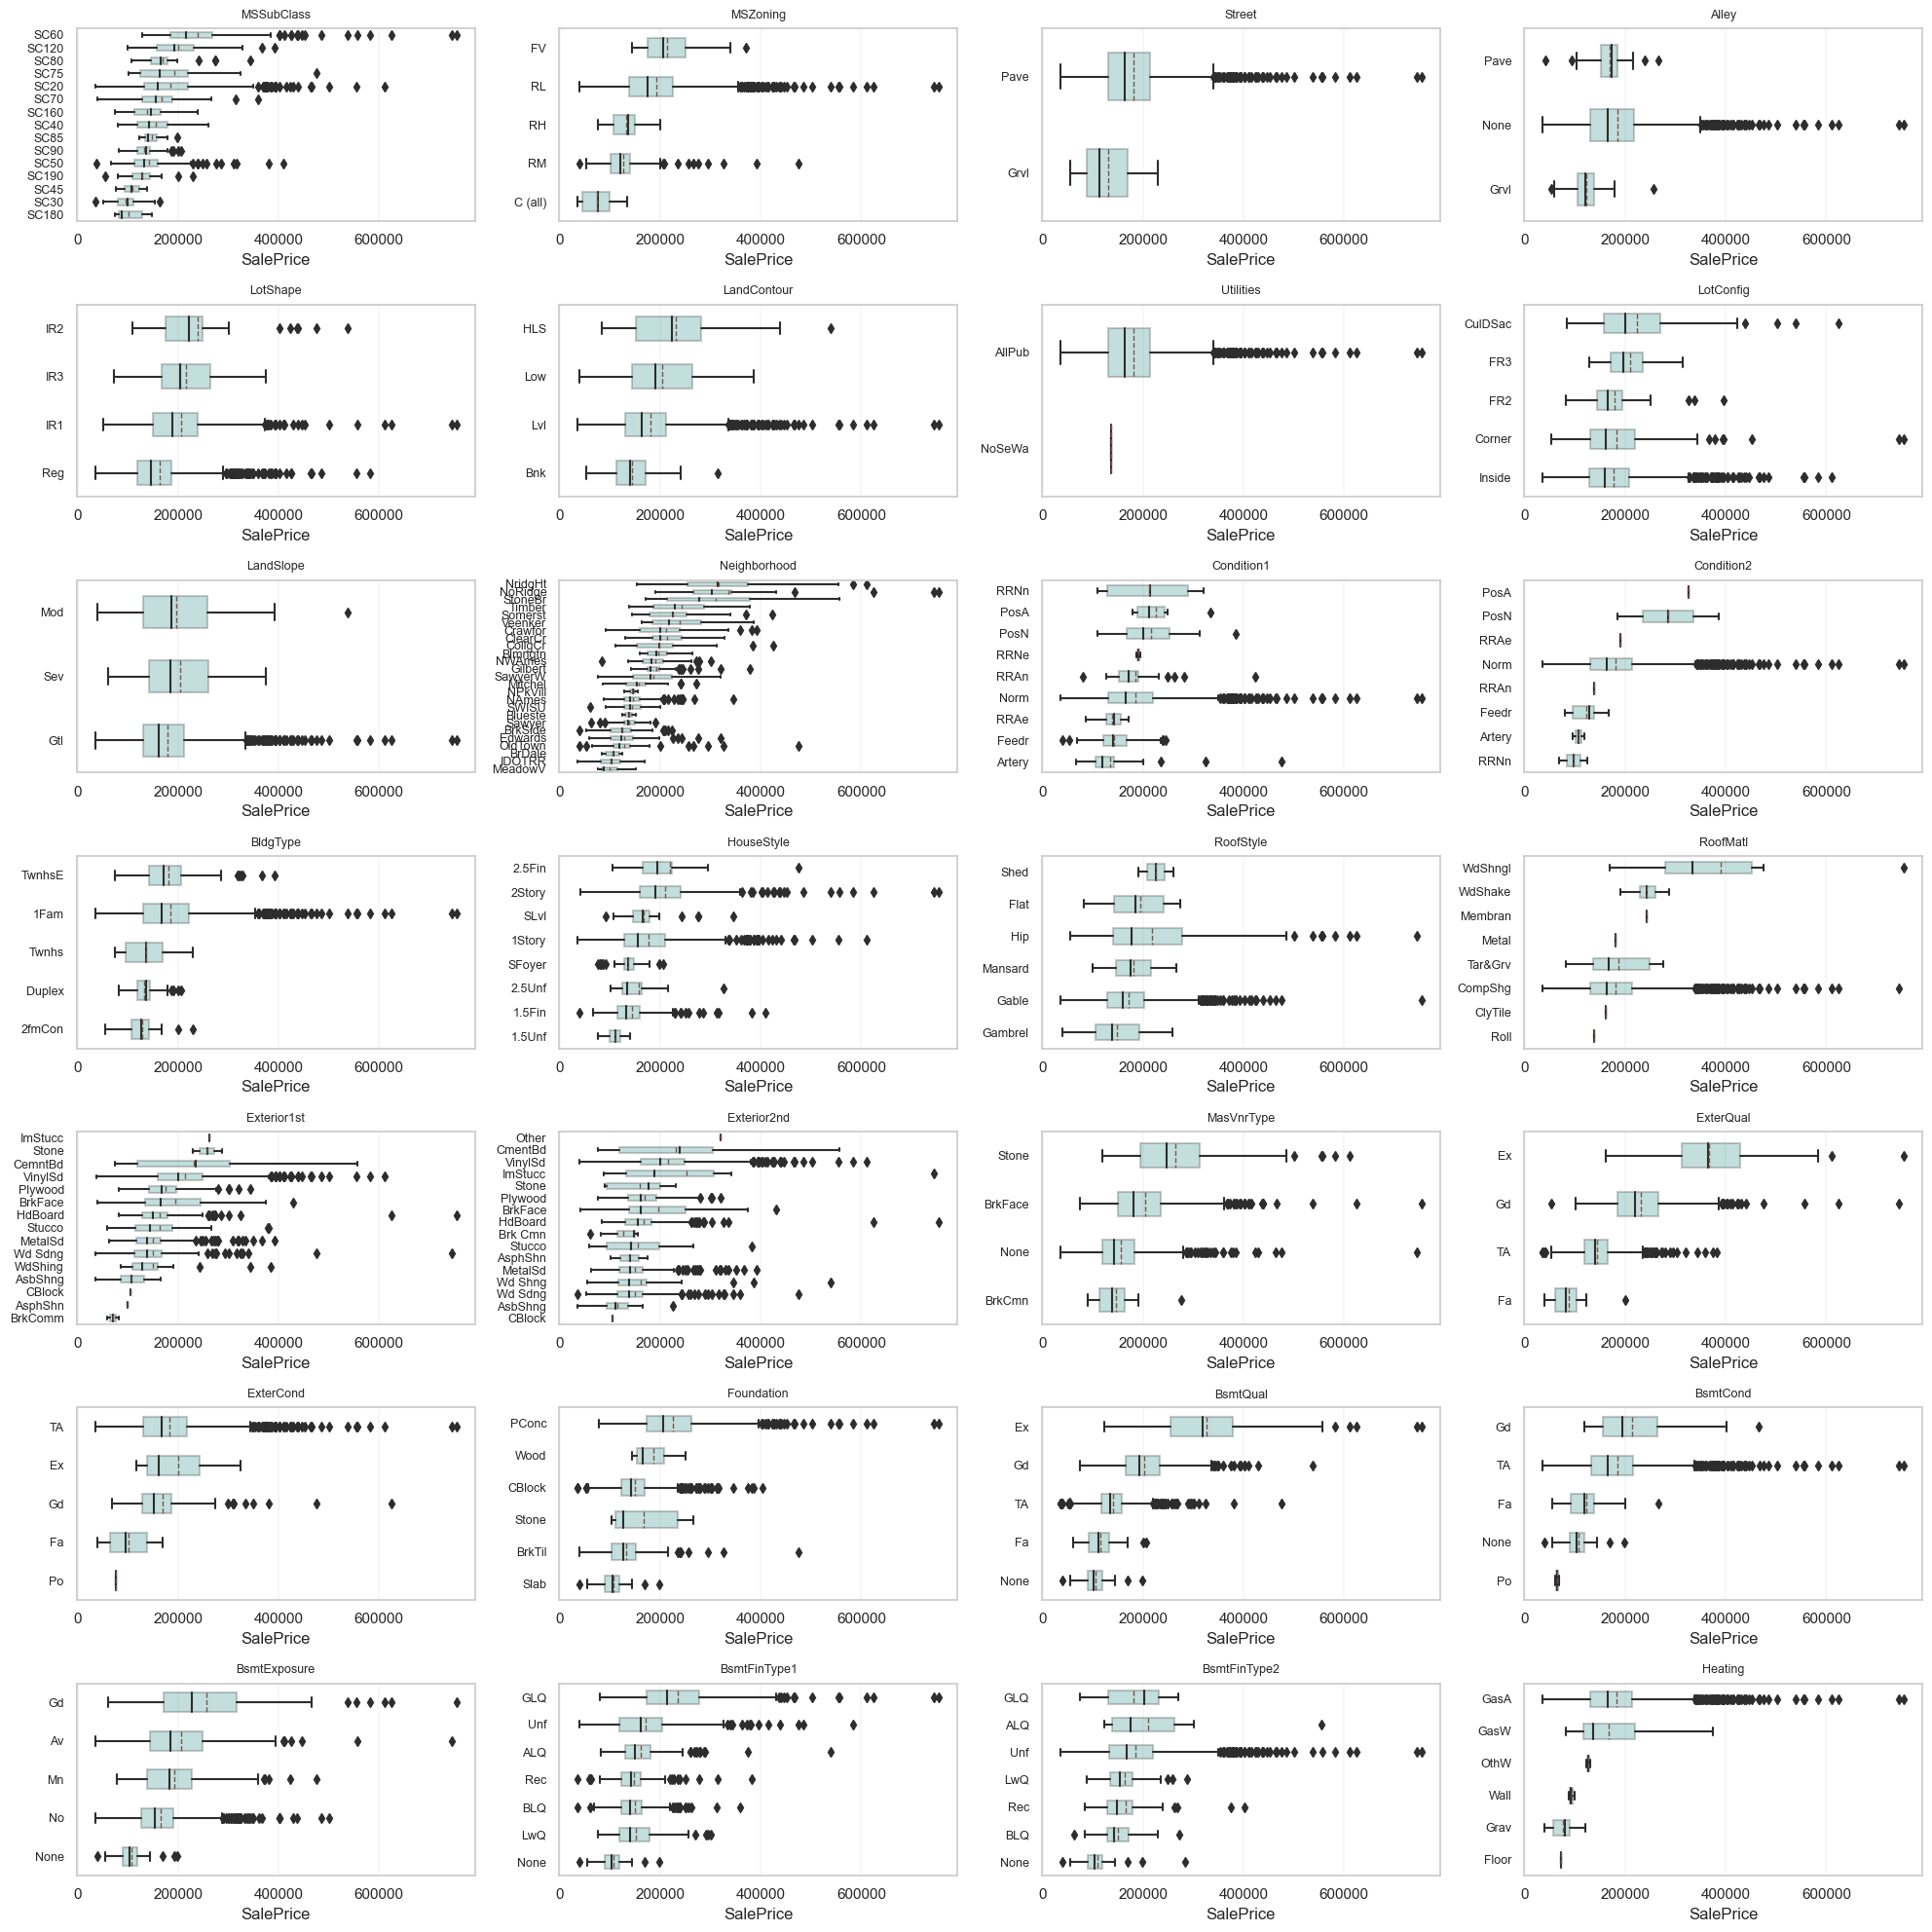

In [212]:
# boxplot for discrete numerical features 

def boxplotDiscFeatures(y, df, col, row, hig, wid): 
    fig, axes = plt.subplots(col, row, figsize=(hig, wid), dpi =100)
    axes = axes.flatten()
    
    for i, j in zip(df.columns[:-1], axes):
        sorted = df.groupby([i])[y].median().sort_values(ascending=False)
        sns.boxplot(x=y,
                    y=i,
                    data=df,
                    palette=palette[0:1],
                    boxprops=dict(alpha=alpha*0.5), 
                    showmeans=True, 
                    meanline=True,
                    meanprops=dict(color=palette[2]),
                    order=sorted.index,
                    width=0.5,
                    ax=j)
                    
        j.tick_params(axis='y', labelsize=9, labelrotation=0)
        j.set_ylabel('', fontsize=0)
        j.xaxis.set_major_locator(MaxNLocator(nbins=5))
        j.set_title(i, fontsize=9, y=1.01, ha='center')
        plt.tight_layout()
        
    

boxplotDiscFeatures('SalePrice',train.select_dtypes('object').join(train['SalePrice']), 7, 4, 20, 20)

Summary: 
* some of the categorical features are ordinal (e.g. ExterQual, ExterCond, etc.), we need to convert these features to their correct data type to ensure that our models treat them appropriately. 
* some of the nominal categorical features have a high cardinality (e.g. Neighborhood, Condition1, Condition2, etc.), we will need to explore these features in greater detail to determine whether they are useful for our models.
* there are a few features with low variability (e.g. Utilities, Street, PoolQC, etc.), we will drop these features from our dataset as they are unlikely to provide any useful information for our models and will only add noise to our dataset.

In [214]:
# # drop features with low variability
# df.drop(['Utilities', 'Street'], axis=1, inplace=True)
# train.drop(['Utilities', 'Street'], axis=1, inplace=True)
# test.drop(['Utilities', 'Street'], axis=1, inplace=True)

## Features Grouping: 

**Bsmt Exposure**: Refers to walkout or garden level walls

BsmtExposure
Gd     226975.00
Av     185850.00
Mn     182450.00
No     154000.00
None   104025.00
Name: SalePrice, dtype: float64

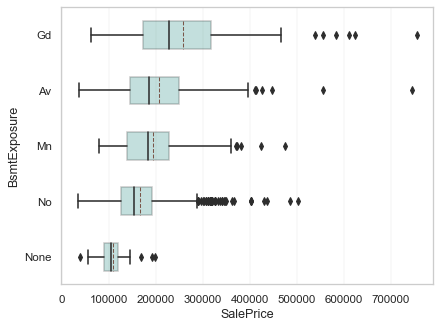

In [215]:
# BsmtExposure 
sns.boxplot(x='SalePrice', y='BsmtExposure', data=df, palette=palette[0:1], boxprops=dict(alpha=alpha*0.5), showmeans=True, meanline=True, meanprops=dict(color=palette[2]), width=0.5, order=['Gd', 'Av', 'Mn', 'No', 'None']) 


(df.groupby(['BsmtExposure']).count()['Id'] / len(df)).sort_values(ascending=False)
df.groupby(['BsmtExposure'])['SalePrice'].median().sort_values(ascending=False)

In [216]:
# map 'Av', 'Mn' in BsmtExposure to Av
df['BsmtExposure'] = df['BsmtExposure'].replace(['Av', 'Mn'], 'Av')
train['BsmtExposure'] = train['BsmtExposure'].replace(['Av', 'Mn'], 'Av')
test['BsmtExposure'] = test['BsmtExposure'].replace(['Av', 'Mn'], 'Av')

**BsmtFinType1 & BsmtFinType2**: Rating of basement finished area

BsmtFinType1
Unf    0.29
GLQ    0.29
ALQ    0.15
Rec    0.10
BLQ    0.09
LwQ    0.05
None   0.03
Name: Id, dtype: float64

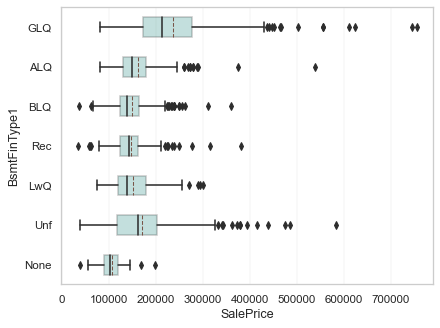

In [217]:
# BsmtFinType1 
sns.boxplot(x='SalePrice', y='BsmtFinType1', data=df, palette=palette[0:1], boxprops=dict(alpha=alpha*0.5), showmeans=True, meanline=True, meanprops=dict(color=palette[2]), width=0.5, order= ['GLQ', 'ALQ', 'BLQ', 'Rec', 'LwQ', 'Unf', 'None']) 


(df.groupby(['BsmtFinType1']).count()['Id'] / len(df)).sort_values(ascending=False)

# df.groupby(['BsmtFinType1'])['SalePrice'].median().sort_values(ascending=False)

Id    Median
BsmtFinType2                
Unf           2493 167000.00
Rec            105 148750.00
LwQ             87 154000.00
None            80 104025.00
BLQ             68 143000.00
ALQ             52 174900.00
GLQ             34 203125.00

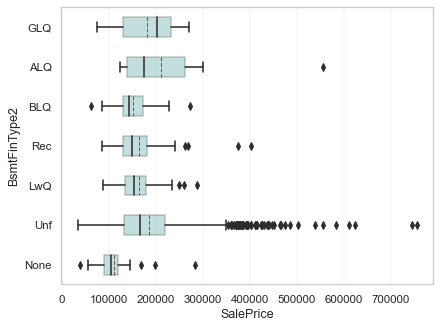

In [218]:
# BsmtFinType2 
sns.boxplot(x='SalePrice', y='BsmtFinType2', data=df, palette=palette[0:1], boxprops=dict(alpha=alpha*0.5), showmeans=True, meanline=True, meanprops=dict(color=palette[2]), width=0.5, order= ['GLQ', 'ALQ', 'BLQ', 'Rec', 'LwQ', 'Unf', 'None']) 


temp = pd.DataFrame((df.groupby(['BsmtFinType2']).count()['Id']))

temp['Median'] = df.groupby(['BsmtFinType2'])['SalePrice'].median()

temp.sort_values(by='Id', ascending=False)


In [219]:
# map 'ALQ', 'BLQ', 'Rec', 'LwQ' in BsmtFinType1 to Av
df['BsmtFinType1'] = df['BsmtFinType1'].replace(['ALQ', 'BLQ', 'Rec', 'LwQ'], 'Av')
train['BsmtFinType1'] = train['BsmtFinType1'].replace(['ALQ', 'BLQ', 'Rec', 'LwQ'], 'Av')
test['BsmtFinType1'] = test['BsmtFinType1'].replace(['ALQ', 'BLQ', 'Rec', 'LwQ'], 'Av')

# map 'ALQ', 'BLQ', 'Rec', 'LwQ' in BsmtFinType2 to Av
df['BsmtFinType2'] = df['BsmtFinType2'].replace(['ALQ', 'BLQ', 'Rec', 'LwQ'], 'Av')
train['BsmtFinType2'] = train['BsmtFinType2'].replace(['ALQ', 'BLQ', 'Rec', 'LwQ'], 'Av')
test['BsmtFinType2'] = test['BsmtFinType2'].replace(['ALQ', 'BLQ', 'Rec', 'LwQ'], 'Av')

**Fence**: Fence quality

Id    Median
Fence                
None   2348 173000.00
GdPrv   118 167500.00
GdWo    112 138750.00
MnPrv   329 137450.00
MnWw     12 130000.00

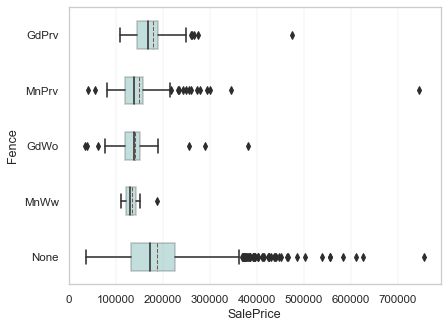

In [220]:
# Fence 

sns.boxplot(x='SalePrice', y='Fence', data=df, palette=palette[0:1], boxprops=dict(alpha=alpha*0.5), showmeans=True, meanline=True, meanprops=dict(color=palette[2]), width=0.5, order= ['GdPrv', 'MnPrv', 'GdWo', 'MnWw', 'None'])


temp = pd.DataFrame((df.groupby(['Fence']).count()['Id']))

temp['Median'] = df.groupby(['Fence'])['SalePrice'].median()

temp.sort_values(by='Median', ascending=False)



In [221]:
# map 'MnPrv', 'GdWo', 'MnWw' in Fence to AvPrv
df['Fence'] = df['Fence'].replace(['MnPrv', 'GdWo', 'MnWw'], 'AvPrv')
train['Fence'] = train['Fence'].replace(['MnPrv', 'GdWo', 'MnWw'], 'AvPrv')
test['Fence'] = test['Fence'].replace(['MnPrv', 'GdWo', 'MnWw'], 'AvPrv') 

**LotConfig**: Lot configuration  

Id    %    Median
LotConfig                     
CulDSac     176 0.06 199262.00
FR3          14 0.00 195450.00
FR2          85 0.03 165000.00
Corner      511 0.18 160000.00
Inside     2133 0.73 159697.50

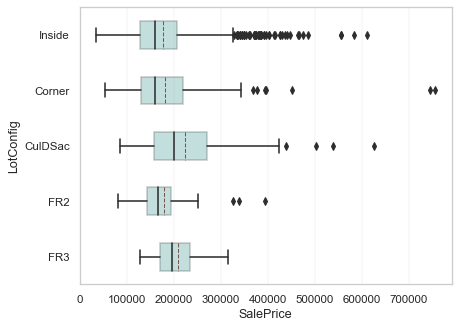

In [222]:
# LotConfig 
sns.boxplot(x='SalePrice', y='LotConfig', data=df, palette=palette[0:1], boxprops=dict(alpha=alpha*0.5), showmeans=True, meanline=True, meanprops=dict(color=palette[2]), width=0.5, order= ['Inside', 'Corner', 'CulDSac', 'FR2', 'FR3'])

temp = pd.DataFrame((df.groupby(['LotConfig']).count()['Id']))
temp['%'] = (df.groupby(['LotConfig']).count()['Id']) / len(df)

temp['Median'] = df.groupby(['LotConfig'])['SalePrice'].median()

temp.sort_values(by='Median', ascending=False)


In [223]:
# map 'CulDSac', 'FR3' in LotConfig to 1 else to 0
df['LotConfig'] = df['LotConfig'].map({'Inside': 0, 'Corner': 0, 'CulDSac': 1, 'FR2': 0, 'FR3': 1})
train['LotConfig'] = train['LotConfig'].map({'Inside': 0, 'Corner': 0, 'CulDSac': 1, 'FR2': 0, 'FR3': 1})
test['LotConfig'] = test['LotConfig'].map({'Inside': 0, 'Corner': 0, 'CulDSac': 1, 'FR2': 0, 'FR3': 1})

**LandSlope**: Slope of property


Id    %    Median
LandSlope                     
Mod         125 0.04 186700.00
Sev          16 0.01 185000.00
Gtl        2778 0.95 161875.00

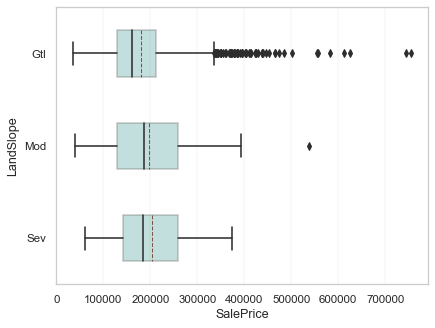

In [224]:
# LandSlope 
sns.boxplot(x='SalePrice', y='LandSlope', data=df, palette=palette[0:1], boxprops=dict(alpha=alpha*0.5), showmeans=True, meanline=True, meanprops=dict(color=palette[2]), width=0.5, order=  ['Gtl', 'Mod', 'Sev'])

temp = pd.DataFrame((df.groupby(['LandSlope']).count()['Id']))
temp['%'] = (df.groupby(['LandSlope']).count()['Id']) / len(df)

temp['Median'] = df.groupby(['LandSlope'])['SalePrice'].median()

temp.sort_values(by='Median', ascending=False)


In [225]:
# map 'Gtl' in LotSlop to 1 else to 0 
df['LandSlope'] = df['LandSlope'].map({'Gtl': 1, 'Mod': 0, 'Sev': 0})
train['LandSlope'] = train['LandSlope'].map({'Gtl': 1, 'Mod': 0, 'Sev': 0})
test['LandSlope'] = test['LandSlope'].map({'Gtl': 1, 'Mod': 0, 'Sev': 0})

**HouseStyle**: Style of dwelling

Id    %    Median
HouseStyle                     
2.5Fin         8 0.00 194000.00
2Story       872 0.30 190000.00
SLvl         128 0.04 164500.00
1Story      1471 0.50 154750.00
SFoyer        83 0.03 135960.00
2.5Unf        24 0.01 133900.00
1.5Fin       314 0.11 132000.00
1.5Unf        19 0.01 111250.00

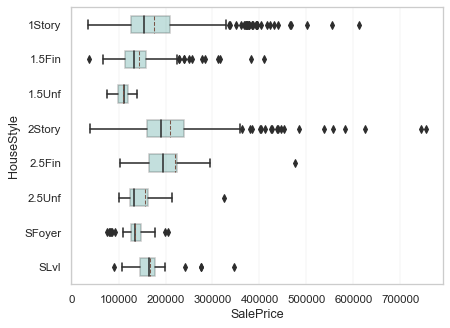

In [226]:

# HouseStyle 
sns.boxplot(x='SalePrice', y='HouseStyle', data=df, palette=palette[0:1], boxprops=dict(alpha=alpha*0.5), showmeans=True, meanline=True, meanprops=dict(color=palette[2]), width=0.5, order= ['1Story', '1.5Fin', '1.5Unf', '2Story', '2.5Fin', '2.5Unf', 'SFoyer', 'SLvl'])

temp = pd.DataFrame((df.groupby(['HouseStyle']).count()['Id']))
temp['%'] = (df.groupby(['HouseStyle']).count()['Id']) / len(df)

temp['Median'] = df.groupby(['HouseStyle'])['SalePrice'].median()

temp.sort_values(by='Median', ascending=False)


In [227]:
# map '1Story', '1.5Fin', '1.5Unf' in HouseStyle to 2; '2Story', '2.5Fin', '2.5Unf' to 3; 'SFoyer', 'SLvl' to 1
df['HouseStyle'] = df['HouseStyle'].map({'1Story': 2, '1.5Fin': 2, '1.5Unf': 2, '2Story': 3, '2.5Fin': 3, '2.5Unf': 3, 'SFoyer': 1, 'SLvl': 1})
train['HouseStyle'] = train['HouseStyle'].map({'1Story': 2, '1.5Fin': 2, '1.5Unf': 2, '2Story': 3, '2.5Fin': 3, '2.5Unf': 3, 'SFoyer': 1, 'SLvl': 1})
test['HouseStyle'] = test['HouseStyle'].map({'1Story': 2, '1.5Fin': 2, '1.5Unf': 2, '2Story': 3, '2.5Fin': 3, '2.5Unf': 3, 'SFoyer': 1, 'SLvl': 1})

**HouseStyle**: Style of dwelling

Id    %    Median
MasVnrType                     
Stone        249 0.09 246839.00
BrkFace      879 0.30 181000.00
None        1766 0.61 143125.00
BrkCmn        25 0.01 139000.00

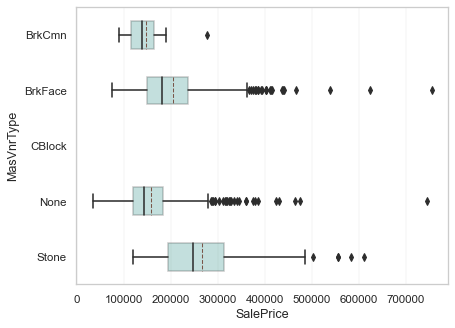

In [228]:
# MasVnrType 
sns.boxplot(x='SalePrice', y='MasVnrType', data=df, palette=palette[0:1], boxprops=dict(alpha=alpha*0.5), showmeans=True, meanline=True, meanprops=dict(color=palette[2]), width=0.5, order= ['BrkCmn', 'BrkFace', 'CBlock', 'None', 'Stone'])

temp = pd.DataFrame((df.groupby(['MasVnrType']).count()['Id']))
temp['%'] = (df.groupby(['MasVnrType']).count()['Id']) / len(df)

temp['Median'] = df.groupby(['MasVnrType'])['SalePrice'].median()

temp.sort_values(by='Median', ascending=False) 


In [229]:
# map 'BrkCmn', 'None' in MasVnrType to 'Other'
df['MasVnrType'] = df['MasVnrType'].replace(['BrkCmn', 'None'], 'Other')
train['MasVnrType'] = train['MasVnrType'].replace(['BrkCmn', 'None'], 'Other')
test['MasVnrType'] = test['MasVnrType'].replace(['BrkCmn', 'None'], 'Other')

**Heating** : Type of heating

Id    %    Median
GarageType                     
BuiltIn      186 0.06 227500.00
Attchd      1723 0.59 185000.00
2Types        23 0.01 159000.00
Basment       36 0.01 148000.00
Detchd       777 0.27 129500.00
CarPort       15 0.01 108000.00
None         159 0.05 100000.00

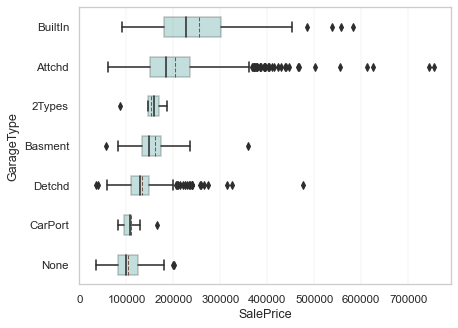

In [230]:
# GarageType 
sns.boxplot(x='SalePrice', y='GarageType', data=df, palette=palette[0:1], boxprops=dict(alpha=alpha*0.5), showmeans=True, meanline=True, meanprops=dict(color=palette[2]), width=0.5, order= df.groupby(['GarageType'])['SalePrice'].median().sort_values(ascending=False).index)

temp = pd.DataFrame((df.groupby(['GarageType']).count()['Id']))
temp['%'] = (df.groupby(['GarageType']).count()['Id']) / len(df)

temp['Median'] = df.groupby(['GarageType'])['SalePrice'].median()

temp.sort_values(by='Median', ascending=False) 


In [231]:
# map 'Attchd', 'BuiltIn' in GarageType to its own category else to other category
df['GarageType'] = df['GarageType'].apply(lambda x: x if x in ['Attchd', 'BuiltIn'] else 'Other')
train['GarageType'] = train['GarageType'].apply(lambda x: x if x in ['Attchd', 'BuiltIn'] else 'Other')
test['GarageType'] = test['GarageType'].apply(lambda x: x if x in ['Attchd', 'BuiltIn'] else 'Other')

**PavedDrive** : Paved driveway 

Id    %    Median
PavedDrive                     
Y           2641 0.90 168500.00
P             62 0.02 132250.00
N            216 0.07 111000.00

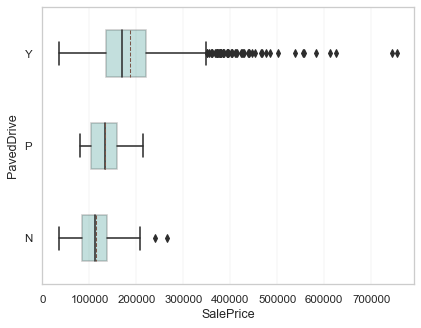

In [232]:
# PavedDrive 
sns.boxplot(x='SalePrice', y='PavedDrive', data=df, palette=palette[0:1], boxprops=dict(alpha=alpha*0.5), showmeans=True, meanline=True, meanprops=dict(color=palette[2]), width=0.5, order= df.groupby(['PavedDrive'])['SalePrice'].median().sort_values(ascending=False).index)

temp = pd.DataFrame((df.groupby(['PavedDrive']).count()['Id']))
temp['%'] = (df.groupby(['PavedDrive']).count()['Id']) / len(df)

temp['Median'] = df.groupby(['PavedDrive'])['SalePrice'].median()

temp.sort_values(by='Median', ascending=False) 


In [233]:
# map 'Y' in PavedDrive to 1 else to 0
df['PavedDrive'] = df['PavedDrive'].map({'Y': 1, 'P': 0, 'N': 0})
train['PavedDrive'] = train['PavedDrive'].map({'Y': 1, 'P': 0, 'N': 0})
test['PavedDrive'] = test['PavedDrive'].map({'Y': 1, 'P': 0, 'N': 0})

## Ordinal Features
convert the following ordinal features to their correct data type

In [234]:
# inspect data set
df.head()

Id MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0        1       SC60       RL        65.00     8450   Pave  None      Reg   
1        2       SC20       RL        80.00     9600   Pave  None      Reg   
2        3       SC60       RL        68.00    11250   Pave  None      IR1   
3        4       SC70       RL        60.00     9550   Pave  None      IR1   
4        5       SC60       RL        84.00    14260   Pave  None      IR1   
...    ...        ...      ...          ...      ...    ...   ...      ...   
1454  2915      SC160       RM        21.00     1936   Pave  None      Reg   
1455  2916      SC160       RM        21.00     1894   Pave  None      Reg   
1456  2917       SC20       RL       160.00    20000   Pave  None      Reg   
1457  2918       SC85       RL        62.00    10441   Pave  None      Reg   
1458  2919       SC60       RL        74.00     9627   Pave  None      Reg   

     LandContour Utilities  LotConfig  LandSlope Neighborhood Condition1  \
0            Lvl    AllPub          0          1      CollgCr       Norm   
1            Lvl    AllPub          0          1      Veenker      Feedr   
2            Lvl    AllPub          0          1      CollgCr       Norm   
3            Lvl    AllPub          0          1      Crawfor       Norm   
4            Lvl    AllPub          0          1      NoRidge       Norm   
...          ...       ...        ...        ...          ...        ...   
1454         Lvl    AllPub          0          1      MeadowV       Norm   
1455         Lvl    AllPub          0          1      MeadowV       Norm   
1456         Lvl    AllPub          0          1      Mitchel       Norm   
1457         Lvl    AllPub          0          1      Mitchel       Norm   
1458         Lvl    AllPub          0          0      Mitchel       Norm   

     Condition2 BldgType  HouseStyle  OverallQual  OverallCond  YearBuilt  \
0          Norm     1Fam           3            7            5       2003   
1          Norm     1Fam           2            6            8       1976   
2          Norm     1Fam           3            7            5       2001   
3          Norm     1Fam           3            7            5       1915   
4          Norm     1Fam           3            8            5       2000   
...         ...      ...         ...          ...          ...        ...   
1454       Norm    Twnhs           3            4            7       1970   
1455       Norm   TwnhsE           3            4            5       1970   
1456       Norm     1Fam           2            5            7       1960   
1457       Norm     1Fam           1            5            5       1992   
1458       Norm     1Fam           3            7            5       1993   

      YearRemodAdd RoofStyle RoofMatl Exterior1st Exterior2nd MasVnrType  \
0             2003     Gable  CompShg     VinylSd     VinylSd    BrkFace   
1             1976     Gable  CompShg     MetalSd     MetalSd      Other   
2             2002     Gable  CompShg     VinylSd     VinylSd    BrkFace   
3             1970     Gable  CompShg     Wd Sdng     Wd Shng      Other   
4             2000     Gable  CompShg     VinylSd     VinylSd    BrkFace   
...            ...       ...      ...         ...         ...        ...   
1454          1970     Gable  CompShg     CemntBd     CmentBd      Other   
1455          1970     Gable  CompShg     CemntBd     CmentBd      Other   
1456          1996     Gable  CompShg     VinylSd     VinylSd      Other   
1457          1992     Gable  CompShg     HdBoard     Wd Shng      Other   
1458          1994     Gable  CompShg     HdBoard     HdBoard    BrkFace   

      MasVnrArea ExterQual ExterCond Foundation BsmtQual BsmtCond  \
0         196.00        Gd        TA      PConc       Gd       TA   
1           0.00        TA        TA     CBlock       Gd       TA   
2         162.00        Gd        TA      PConc       Gd       TA   
3           0.00        TA        TA     Brk

In [235]:
# function to convert nominal to ordinal
def apply_ordinal_encoding(df, features, mapping):
    for feature in features:
        df[feature] = df[feature].map(mapping)
    return df


# convert nominal to ordinal Quality and Condition features
QC_features_full = ['ExterQual', 'ExterCond', 'KitchenQual', 'HeatingQC']
Qual_rate_dict = {
    'Po': 0,  # Poor
    'Fa': 1,  # Fair
    'TA': 1,  # Average/Typical
    'Gd': 2,  # Good
    'Ex': 3   # Excellent
}

df = apply_ordinal_encoding(df, QC_features_full, Qual_rate_dict)
train = apply_ordinal_encoding(train, QC_features_full, Qual_rate_dict)
test = apply_ordinal_encoding(test, QC_features_full, Qual_rate_dict)



# convert nominal to ordinal Quality and Condition for features with missing values
QC_features = ['PoolQC','FireplaceQu','GarageCond','GarageQual','BsmtCond','BsmtQual']
QC_rate_dict = {
    'None':0, # 'None
    'Po': 0,  # Poor
    'Fa': 1,  # Fair
    'TA': 1,  # Average/Typical
    'Gd': 2,  # Good
    'Ex': 3   # Excellent
}

df = apply_ordinal_encoding(df, QC_features, QC_rate_dict)
train = apply_ordinal_encoding(train, QC_features, QC_rate_dict)
test = apply_ordinal_encoding(test, QC_features, QC_rate_dict)


# convert nominal to ordinal BsmtExposure and BsmtFinType features
BsmtExp_features = ['BsmtExposure']
BsmtExposure_dict = {
    'None':0, # No Exposure
    'No':1, # No Basement
    'Av':2, # Average Exposure
    'Gd':3} # Good Exposure   

df = apply_ordinal_encoding(df, BsmtExp_features, BsmtExposure_dict)
train = apply_ordinal_encoding(train, BsmtExp_features, BsmtExposure_dict)
test = apply_ordinal_encoding(test, BsmtExp_features, BsmtExposure_dict)



# convert nominal to ordinal BsmtFinType features
BsmtFin_features = ['BsmtFinType1','BsmtFinType2']
BsmtFinType_dict = {
    'None':0, # No Basement
    'Unf':1, # Unfinshed
    'Av':2, # Grouped Average Exposure
    'GLQ':3} # Good Living Quarters

df = apply_ordinal_encoding(df, BsmtFin_features, BsmtFinType_dict)
train = apply_ordinal_encoding(train, BsmtFin_features, BsmtFinType_dict)
test = apply_ordinal_encoding(test, BsmtFin_features, BsmtFinType_dict)



# convert nominal to ordinal CentralAir feature
YesNo_features = ['CentralAir']
YesNo_dict = {
    'N':0, #  No
    'Y':1 #  Yes
}

df = apply_ordinal_encoding(df, YesNo_features, YesNo_dict)
train = apply_ordinal_encoding(train, YesNo_features, YesNo_dict)
test = apply_ordinal_encoding(test, YesNo_features, YesNo_dict)


# convert nominal to ordinal GarageFinish
GarageFinish_features = ['GarageFinish']
GarageFinish_dict = {
    'None':0, # No Garage
    'Unf':1, # Unfinished
    'RFn':2, # Rough Finished
    'Fin':3} # Finished
    
df = apply_ordinal_encoding(df, GarageFinish_features, GarageFinish_dict)
train = apply_ordinal_encoding(train, GarageFinish_features, GarageFinish_dict)
test = apply_ordinal_encoding(test, GarageFinish_features, GarageFinish_dict)
 
 
# convert nominal to ordinal Fence feature
fence_features = ['Fence']
fence_dict = {
    'None':0, # No Fence
    'AvPrv':1, # Average Privacy
    'GdPrv':2} # Good Privacy
    
df = apply_ordinal_encoding(df, fence_features, fence_dict)
train = apply_ordinal_encoding(train, fence_features, fence_dict)
test = apply_ordinal_encoding(test, fence_features, fence_dict)

# 3. Feature Engineering and Selection
Feature engineering is an essential step in building machine learning models, as it can significantly improve model performance by creating new features or transforming existing ones. In this section, we'll explore different steps for feature engineering and selection in the dataset. The goal of this section is to create a dataset that is ready for training our machine learning models. 

**Outliers**: There seems to be 2 extreme outliers on the bottom right, really large houses that sold for really cheap. More generally, the author of the dataset recommends removing 'any houses with more than 4000 square feet' from the dataset.
Reference : https://ww2.amstat.org/publications/jse/v19n3/decock.pdf

In [236]:
# remove outliers GrLivArea > 4000
df = df.drop(df[(df['GrLivArea']>4000)].index)
train = train.drop(train[(train['GrLivArea']>4000)].index)



In [237]:
# create new feature for total area and drop old features
df['TotalSF'] = df['TotalBsmtSF'] + df['1stFlrSF'] + df['2ndFlrSF']
train['TotalSF'] = train['TotalBsmtSF'] + train['1stFlrSF'] + train['2ndFlrSF']
test['TotalSF'] = test['TotalBsmtSF'] + test['1stFlrSF'] + test['2ndFlrSF']

In [241]:
# create new feature for total bathrooms and drop old features 
df['TotalBath'] = df['FullBath'] + df['HalfBath']*0.5 + df['BsmtFullBath'] + df['BsmtHalfBath']*0.5
train['TotalBath'] = train['FullBath'] + train['HalfBath']*0.5 + train['BsmtFullBath'] + train['BsmtHalfBath']*0.5
test['TotalBath'] = test['FullBath'] + test['HalfBath']*0.5 + test['BsmtFullBath'] + test['BsmtHalfBath']*0.5


In [242]:
# create new feature for YearRemodAgg houses and drop old features 
df['YearRemodAgg'] = df[['YearRemodAdd', 'YearBuilt']].max(axis=1)
train['YearRemodAgg'] = train[['YearRemodAdd', 'YearBuilt']].max(axis=1)
test['YearRemodAgg'] = test[['YearRemodAdd', 'YearBuilt']].max(axis=1)


In [243]:
# create new feature for total porch area and drop old features
df['TotalPorchSF'] = df['OpenPorchSF'] + df['EnclosedPorch'] + df['3SsnPorch'] + df['ScreenPorch']
train['TotalPorchSF'] = train['OpenPorchSF'] + train['EnclosedPorch'] + train['3SsnPorch'] + train['ScreenPorch']
test['TotalPorchSF'] = test['OpenPorchSF'] + test['EnclosedPorch'] + test['3SsnPorch'] + test['ScreenPorch']


In [244]:
# is a new building
df['IsNew'] = df['YearBuilt'].apply(lambda x: 1 if x > 2000 else 0)
train['IsNew'] = train['YearBuilt'].apply(lambda x: 1 if x > 2000 else 0)
test['IsNew'] = test['YearBuilt'].apply(lambda x: 1 if x > 2000 else 0)

In [245]:
# LotArea condition
df['AreaCondition'] = df['LotArea'] * df['OverallCond']
train['AreaCondition'] = train['LotArea'] * train['OverallCond']
test['AreaCondition'] = test['LotArea'] * test['OverallCond']

# totalSF condition 
df['TotalSFCondition'] = df['TotalSF'] * df['OverallCond']
train['TotalSFCondition'] = train['TotalSF'] * train['OverallCond']
test['TotalSFCondition'] = test['TotalSF'] * test['OverallCond']

# GarageArea condition
df['GarageAreaCondition'] = df['GarageArea'] * df['GarageCond']
train['GarageAreaCondition'] = train['GarageArea'] * train['GarageCond']
test['GarageAreaCondition'] = test['GarageArea'] * test['GarageCond']

# TotalBsmntSF condition
df['TotalBsmntSFCondition'] = df['TotalBsmtSF'] * df['BsmtCond']
train['TotalBsmntSFCondition'] = train['TotalBsmtSF'] * train['BsmtCond']
test['TotalBsmntSFCondition'] = test['TotalBsmtSF'] * test['BsmtCond']


In [246]:
# LotArea quality 
df['AreaQuality'] = df['LotArea'] * df['OverallQual']
train['AreaQuality'] = train['LotArea'] * train['OverallQual']
test['AreaQuality'] = test['LotArea'] * test['OverallQual']

# totalSF quality
df['TotalSFQuality'] = df['TotalSF'] * df['OverallQual']
train['TotalSFQuality'] = train['TotalSF'] * train['OverallQual']
test['TotalSFQuality'] = test['TotalSF'] * test['OverallQual']
 
# GarageArea quality
df['GarageAreaQuality'] = df['GarageArea'] * df['GarageQual']
train['GarageAreaQuality'] = train['GarageArea'] * train['GarageQual']
test['GarageAreaQuality'] = test['GarageArea'] * test['GarageQual']

# TotalBsmntSF quality
df['TotalBsmntSFQuality'] = df['TotalBsmtSF'] * df['BsmtQual']
train['TotalBsmntSFQuality'] = train['TotalBsmtSF'] * train['BsmtQual']
test['TotalBsmntSFQuality'] = test['TotalBsmtSF'] * test['BsmtQual']

In [247]:
# are per bedroom 
df['AreaPerBedroom'] = df['GrLivArea'] / df['BedroomAbvGr']
train['AreaPerBedroom'] = train['GrLivArea'] / train['BedroomAbvGr']
test['AreaPerBedroom'] = test['GrLivArea'] / test['BedroomAbvGr']

# totalSF per bedroom
df['TotalSFPerBedroom'] = df['TotalSF'] / df['BedroomAbvGr']
train['TotalSFPerBedroom'] = train['TotalSF'] / train['BedroomAbvGr']
test['TotalSFPerBedroom'] = test['TotalSF'] / test['BedroomAbvGr']


## Corrolation Analysis 

**Pearson Correlation** is a statistical measure that expresses the extent to which two variables are linearly related. In other words, it measures the strength of the relationship between two variables. The value of the correlation coefficient ranges from -1 to 1. A value of 1 indicates a perfect positive linear relationship between the two variables, a value of -1 indicates a perfect negative linear relationship, and a value of 0 indicates no linear relationship between the two variables.

We can observe that there are a number of features that are highly correlated with the target variable. At the same time, there are also a number of features that are highly correlated with each other (e.g. GarageArea and GarageCars, TotalSF and 1stFlrSF). This indicates that we can remove some of the features to reduce the dimensionality of our dataset and improve the performance of our models. 

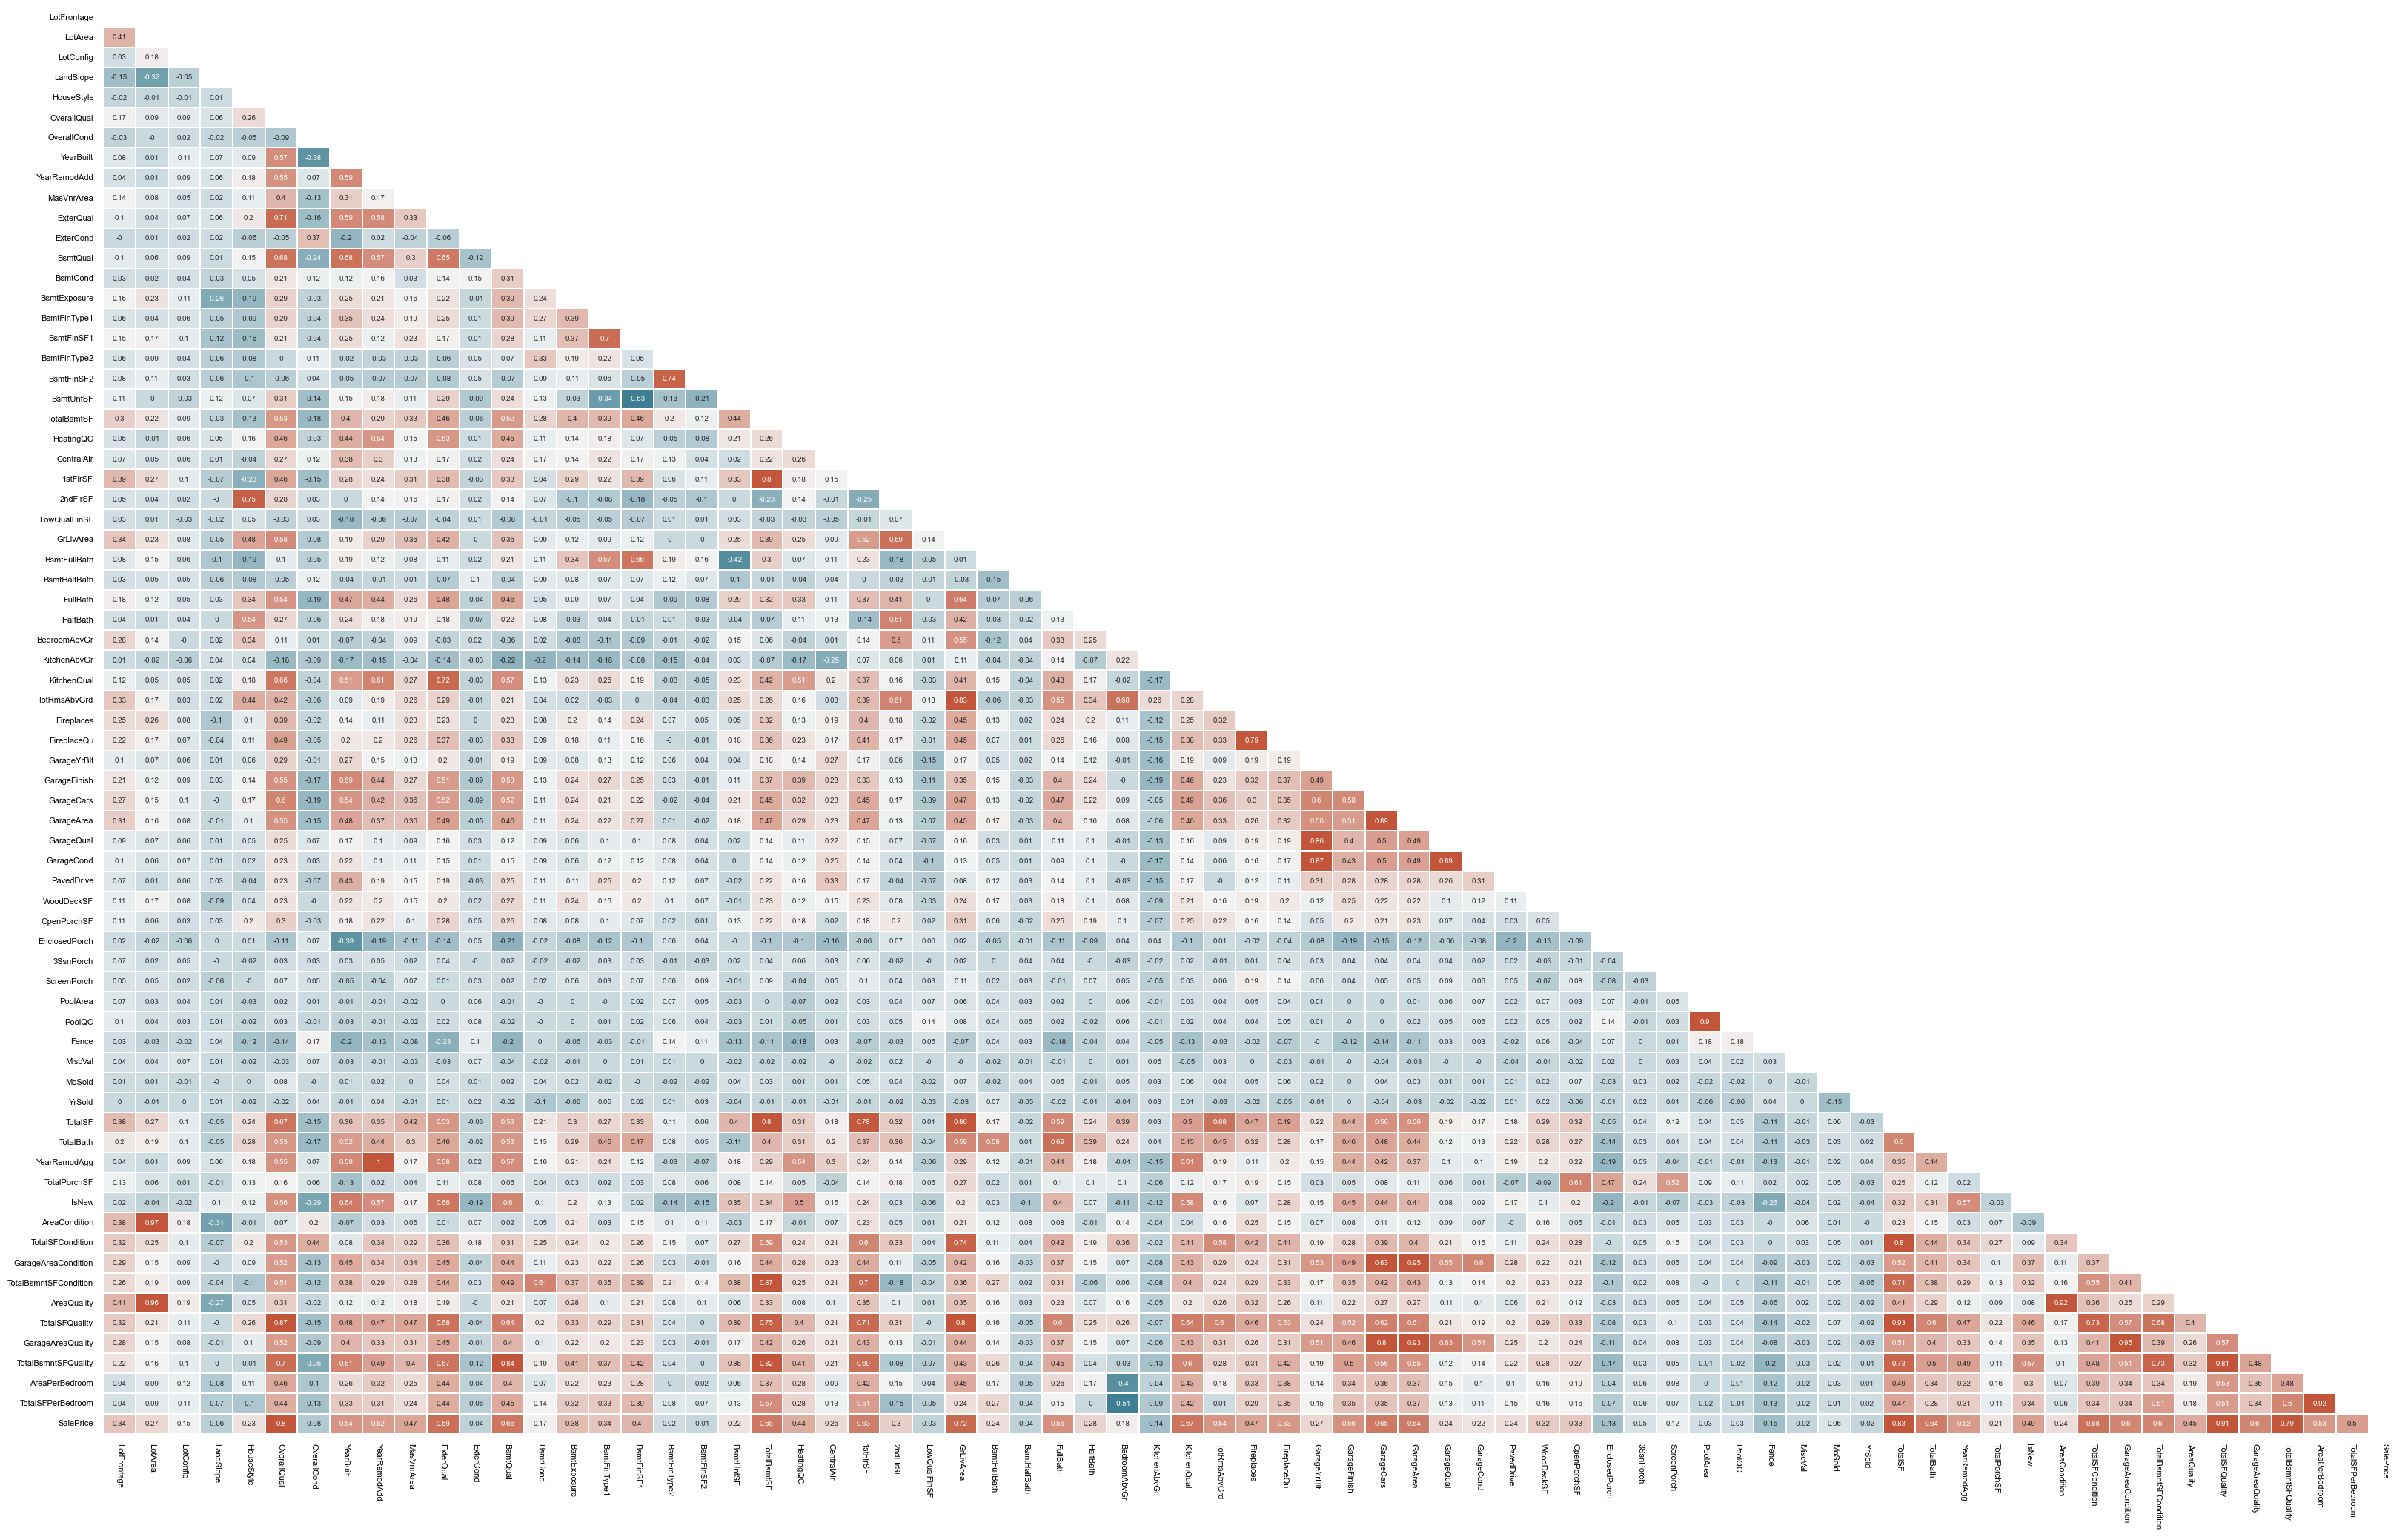

In [249]:
# correlation plot for numerical features
def NumericCorrPlot(df):  
    # Rearrange the columns to place 'SalePrice' at the end
    cols = [col for col in df.columns if col != 'SalePrice' and col != 'Id']
    cols.append('SalePrice')
    df = df[cols]

    cm = sns.diverging_palette(220, 20, sep=5, as_cmap=True)
    corr = df.select_dtypes(include=[np.number]).corr().round(2)
    mask = np.zeros_like(corr)
    mask[np.triu_indices_from(mask)] = True
    with sns.axes_style("white"):
        f, ax = plt.subplots(figsize=(40, 25), dpi=100)
        ax = sns.heatmap(corr,
                         mask=mask,
                         vmin=-0.5,
                         vmax=0.8,
                         linewidths=.25,
                         annot=True,
                         cmap=cm,
                         annot_kws={"size": 7},
                         cbar=False)
        ax.set_xticklabels(ax.get_xmajorticklabels(), fontsize=8, rotation=270, ha='center', color='black')
        ax.set_yticklabels(ax.get_ymajorticklabels(), fontsize=8, ha='right', rotation=0, va='center', color='black')


NumericCorrPlot(train)


## Normalisation and Transformation

**Normalisation** is a process of transforming the values of numeric columns in the dataset to a common scale, without distorting differences in the ranges of values. Normalisation is a common requirement for many machine learning algorithms. In addition, normalisation can help speed up the training process and improve the performance of our models.

**Transformation** is a process of converting data from one format or structure into another format or structure. Transformation is a common requirement for many machine learning algorithms. In addition, transformation can help speed up the training process and improve the performance of our models.

**Log Transformations**: As we have noted at the beginning of the EDA section, the target variable is not normally distributed. This is important because certain machine learning algorithms assume that the input data is normally distributed. We will apply a log transformation to the target variable to make it more normally distributed. This will allow our models to make better predictions.

In [252]:
# normalise skewed features
temp = train.copy()
for col in temp.select_dtypes(include=[np.number]).columns:
    temp[col] = np.log1p(temp[col])
after = temp.select_dtypes(include=[np.number]).drop(['Id'], axis=1).corr()['SalePrice'].sort_values(ascending=False)    
before = train.select_dtypes(include=[np.number]).drop(['Id'], axis=1).corr()['SalePrice'].sort_values(ascending=False)
((after - before)).sort_values(ascending=False)[:10]

AreaQuality     0.21
AreaCondition   0.13
OpenPorchSF     0.13
LotArea         0.13
TotalPorchSF    0.10
GarageCond      0.10
CentralAir      0.10
GarageQual      0.09
OverallCond     0.08
BsmtFinType2    0.07
Name: SalePrice, dtype: float64

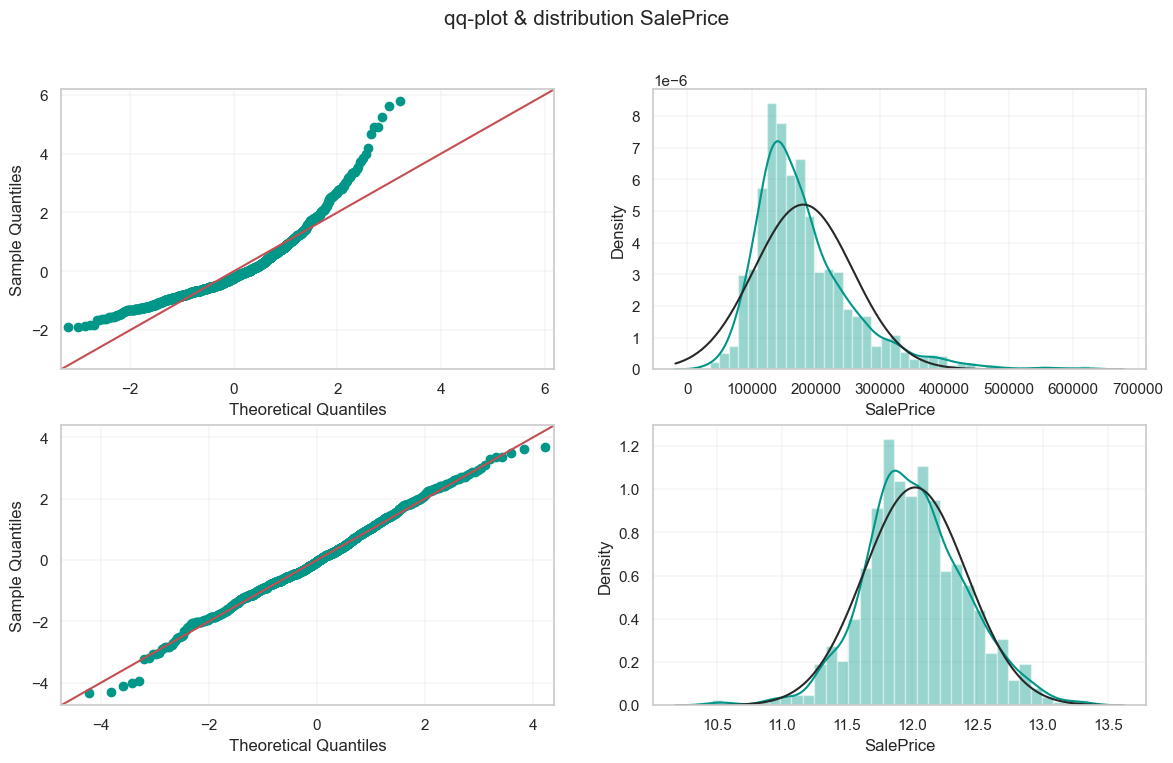

In [253]:
# plot the distribution of SalePrice before and after normalisation
def sekewness(df, col):
    fig, ax = plt.subplots(2,2, figsize= (14,8), dpi = 100)
    fig.suptitle(f"qq-plot & distribution {col}", fontsize= 15)
    sm.qqplot(df[col], stats.t, distargs=(4,),fit=True, line="45", ax = ax[0,0])
    sns.distplot(df[col], kde = True, hist=True, fit = stats.norm, ax = ax[0, 1])


    sm.qqplot(np.log1p(df[col]), stats.t, distargs=(4,),fit=True, line="45", ax = ax[1,0])
    sns.distplot(np.log1p(df[col]), kde = True, hist=True, fit = stats.norm, ax = ax[1, 1])
    plt.show()

sekewness(train, 'SalePrice')

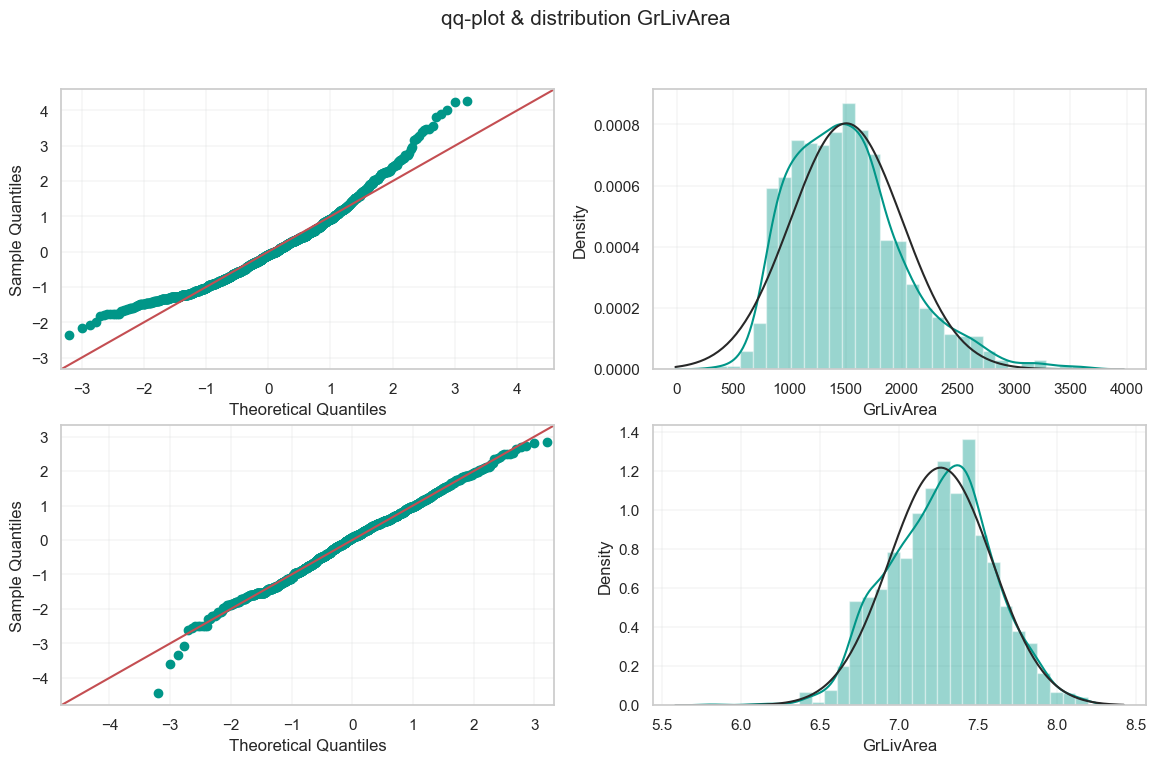

In [254]:
# inspect log transform the GrLivArea feature
sekewness(train, 'GrLivArea')

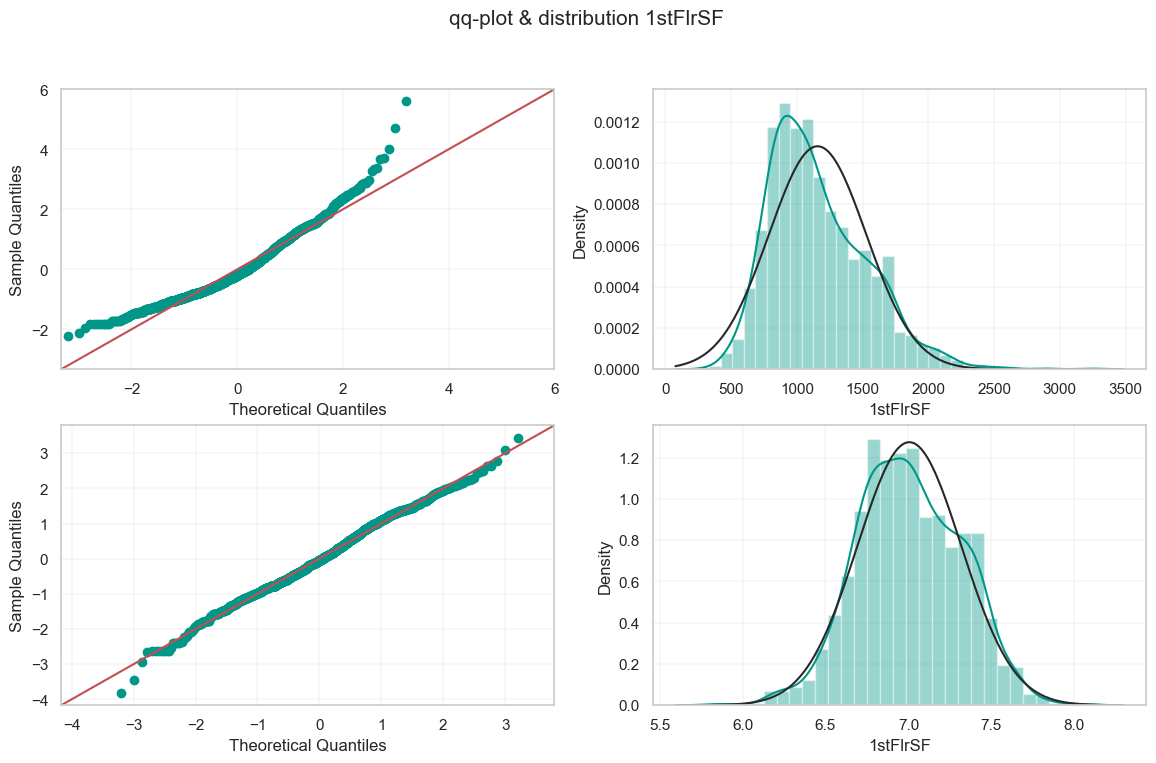

In [255]:
# inspect log transform the 1StFlrSF feature
sekewness(train, '1stFlrSF')

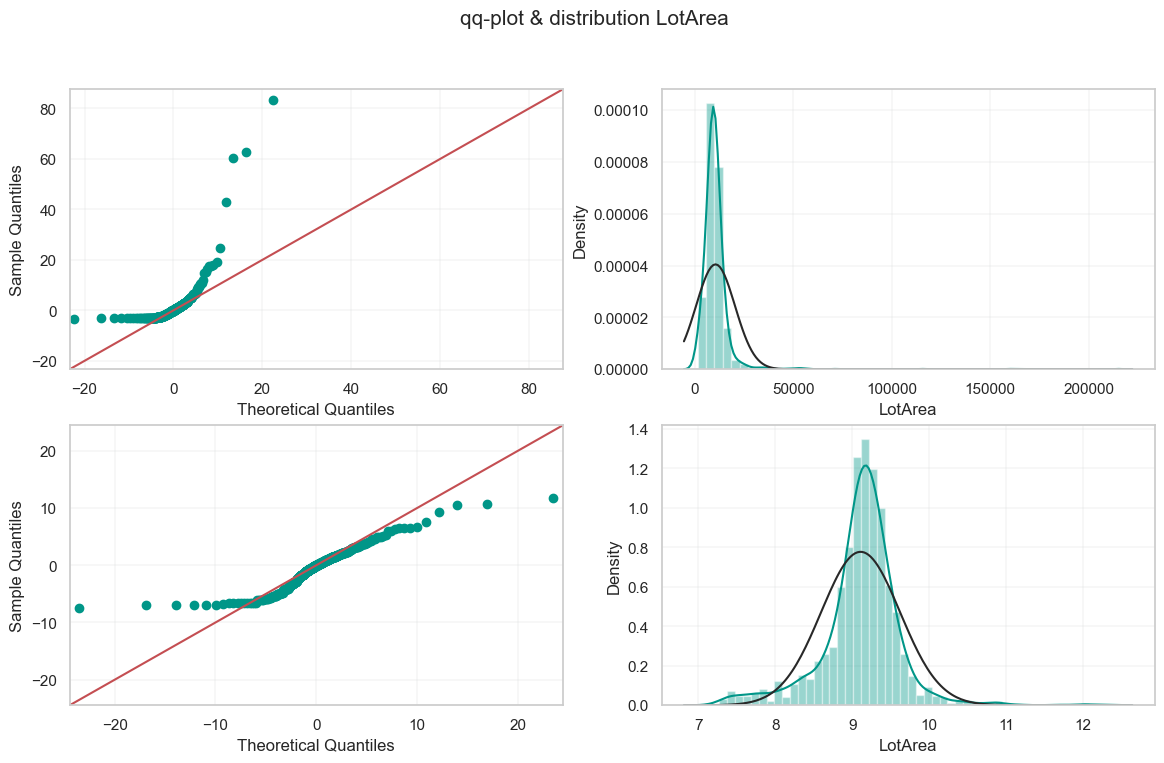

In [256]:
# inspect log transform the LotArea feature
sekewness(train, 'LotArea')

In [257]:
# apply log transform to skewed features
logNorm = ['GrLivArea',  'SalePrice', 'LotArea',  'AreaCondition', 'AreaQuality','LotFrontage','TotalPorchSF'] #['1stFlrSF', 'GrLivArea',  'SalePrice', 'LotArea',  'AreaCondition', 'TotalSF', 'AreaQuality','TotalSFQuality' , 'TotalBsmtSF','LotFrontage', 'LotArea','TotalPorchSF']
for col in logNorm:
    if col != 'SalePrice':
        train[col] = np.log1p(train[col])
        df[col] = np.log1p(df[col])
        test[col] = np.log1p(test[col])
    else:
        train[col] = np.log1p(train[col])
        df[col] = np.log1p(df[col])

**Normalise Numerical features**: For the remaining numerical features will use the min-max scaling method to normalise the numerical features. This method scales the values of each feature between 0 and 1. The min-max scaling method is less sensitive to outliers than other scaling methods.

In [258]:
# Normalize numerical features min max scaler 
scaler = MinMaxScaler()

# fit and transform train data
train_drop = logNorm.append('Id')
train[train.drop(['Id', 'SalePrice'], axis=1).select_dtypes(include=[np.number]).columns] = scaler.fit_transform(train[train.drop(['Id', 'SalePrice'], axis=1).select_dtypes(include=[np.number]).columns])

# transform test data
test_drop =  logNorm.remove('SalePrice')
test[test.drop(['Id'], axis=1).select_dtypes(include=[np.number]).columns] = scaler.transform(test[test.drop(['Id'], axis=1).select_dtypes(include=[np.number]).columns])

**Cardinality**: We will start our transformation by grouping all categorical features with frequency less than 2.5% to be grouped into "Other", this will reduce the number of features and reduce the dimensionality of the dataset.

In [259]:
# reduce the cardinality of categorical features by grouping rare categories into 'Other'
def group_rare_categories(train, test, threshold=0.025):
    for col in train.select_dtypes('object').columns:
        value_counts = train[col].value_counts(normalize=True)

        mask = value_counts < threshold
        rare_categories = value_counts[mask].index.tolist()

        train[col] = train[col].apply(lambda x: 'Other' if x in rare_categories else x)
        
        # Replace categories in test set that are not present in train set with 'Other'
        test[col] = test[col].apply(lambda x: 'Other' if x not in train[col].unique() or x in rare_categories else x)

    return (train, test)

train, test = group_rare_categories(train, test)


**OneHot Encoding**: convert all categorical features to numerical features using one-hot encoding. This will allow our models to treat these features as numerical features and make better predictions.

In [260]:
# one hot encoding for categorical features
def one_hot_encode(df, cols):
    ohe = OneHotEncoder(handle_unknown='ignore', sparse=False)
    ohe_df = pd.DataFrame(ohe.fit_transform(df[cols]), columns=ohe.get_feature_names_out(cols))
    ohe_df.index = df.index  
    df = pd.concat([df, ohe_df], axis=1)
    df.drop(cols, axis=1, inplace=True)
    return df

train = one_hot_encode(train, train.select_dtypes('object').columns)
test = one_hot_encode(test, test.select_dtypes('object').columns)

## PCA Analysis 
Now that we have transformed our dataset, we can apply PCA to reduce the dimensionality of our dataset. PCA is a dimensionality reduction technique that can be used to reduce the number of features in a dataset while retaining most of the information. In this section, we will apply PCA to our dataset and determine the optimal number of components to use for our models.

# 4. Model Selection and Tuning

## 4.1 Data Preparation

In [261]:
# prep training and test data for modelling
df = pd.concat([train, test], axis=0, sort=False).copy(deep=True)
df.drop(['SalePrice'], axis=1, inplace=True)


X=df[df['Id'].isin(train['Id'].values)].copy()
y = train['SalePrice'] 

X_test=df[df['Id'].isin(test['Id'].values)].copy()

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state = 0)

In [262]:
# fill missing values with 0
for i in X_train.columns:
    if X_train[i].isnull().sum() > 0:
        X_train[i].fillna(0, inplace=True)
    if X_valid[i].isnull().sum() > 0:
        X_valid[i].fillna(0, inplace=True)
    if X_test[i].isnull().sum() > 0:
        X_test[i].fillna(0, inplace=True)

## 4.2 Model selection and hyperparameter tuning

### Grid Search Cross Validation 
To find the best hyperparameters for our models, we will use grid search cross-validation. Grid search cross-validation will help us find the best combination of hyperparameters for our models by evaluating all possible combinations of hyperparameters in the grid. We will use **RandomizedSearchCV** to find the best hyperparameters for our models, as it is more efficient and scales better to large number of features than GridSearchCV.


In [264]:
# define algorithms and parameters to be used for the girdsearch
algorithms = [
    GradientBoostingRegressor(random_state=0),
    ExtraTreesRegressor(random_state=0),
    XGBRegressor(random_state=0),
    LGBMRegressor(random_state=0),
    HistGradientBoostingRegressor(random_state=0),
    CatBoostRegressor(random_state=0, verbose=0)]

param_grid = [
    # parameters for GradientBoostingRegressor
    {'learning_rate': [0.05, 0.1, 0.15, 0.2],
     'min_samples_split': [3, 7, 11], 
     'min_samples_leaf': [2, 4, 6],
     'max_depth': [2, 5, 8],
     'n_estimators': [200, 250, 300],
     'max_features': ['auto', 'sqrt', 'log2']},
    

    # parameters for ExtraTreesRegressor
    {'max_depth': [30, 40, 50],
     'min_samples_leaf': [1, 2, 3],
     'min_samples_split': [3, 6, 9],
     'n_estimators': [200,  250, 300],
     'max_features': ['auto', 'sqrt', 'log2']},
    
    # parameters for XGBRegressor
    {'learning_rate': [ 0.025, 0.05, 0.075],
     'max_depth': [8, 9, 10],
     'min_child_weight': [4, 5, 6],
     'n_estimators': [200, 225, 250],
     'subsample': [0.45, 0.5, 0.55],
     'colsample_bytree': [0.25, 0.55, 0.75],
     'gamma': [0, 0.1, 0.25]},
    
    # parameters for LGBMRegressor
    {'learning_rate': [0.1, 0.15, 0.2],
     'max_depth': [3, 4, 5],
     'n_estimators': [275, 350, 500],
     'num_leaves': [10, 20, 40],
     'min_child_samples': [2, 4, 6],
     'subsample': [0.25, 0.45, 0.6]},
    
    # parameters for HistGradientBoostingRegressor
    {'learning_rate': [0.8, 0.11, 0.15],
     'max_depth': [1, 2, 3, 4],
     'min_samples_leaf': [3, 4, 5],
     'max_iter': [225, 250, 275],
     'max_leaf_nodes': [10, 20, None]},
    
    # parameters for CatBoostRegressor
    {'learning_rate': [0.07, 0.08, 0.09],
     'depth': [4, 5, 6],
     'l2_leaf_reg': [0.1, 0.25, 0.5],
     'n_estimators': [275, 300, 325],
     'border_count': [64, 96, 128],
     'bagging_temperature': [1.25, 1.5, 1.75],
     'random_strength': [0.25, 0.5, 0.75]}
]




# Perform random search to find the best parameters for each algorithm using RandomizedSearchCV

best_params = []
for i, algo in tqdm(enumerate(algorithms)):
    start = time.time()
    rand_search = RandomizedSearchCV(algo, param_grid[i],
                                     n_iter=100,
                                     cv=10, n_jobs=-1, random_state=0)
    rand_search.fit(X_train, y_train)
    best_params.append(rand_search.best_params_)
    end = time.time()
    print(f"{algo.__class__.__name__} Time taken to fit: {round(((end - start) / 60),2)} minutes | Best parameters: {rand_search.best_params_}")
    
# Update the pipeline with the best parameters for each algorithm
for i, algo in enumerate(algorithms):
    algo.set_params(**best_params[i])

# Fit the final pipeline with the best parameters
for algo in algorithms:
    algo.fit(X_train, y_train)

0it [00:00, ?it/s]

GradientBoostingRegressor Time taken to fit: 0.99 minutes | Best parameters: {'n_estimators': 250, 'min_samples_split': 3, 'min_samples_leaf': 4, 'max_features': 'log2', 'max_depth': 5, 'learning_rate': 0.05}
ExtraTreesRegressor Time taken to fit: 1.08 minutes | Best parameters: {'n_estimators': 250, 'min_samples_split': 3, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 40}
XGBRegressor Time taken to fit: 2.9 minutes | Best parameters: {'subsample': 0.45, 'n_estimators': 250, 'min_child_weight': 6, 'max_depth': 9, 'learning_rate': 0.05, 'gamma': 0, 'colsample_bytree': 0.25}
LGBMRegressor Time taken to fit: 0.7 minutes | Best parameters: {'subsample': 0.6, 'num_leaves': 20, 'n_estimators': 350, 'min_child_samples': 4, 'max_depth': 4, 'learning_rate': 0.1}
HistGradientBoostingRegressor Time taken to fit: 2.35 minutes | Best parameters: {'min_samples_leaf': 3, 'max_leaf_nodes': 10, 'max_iter': 250, 'max_depth': 4, 'learning_rate': 0.11}
CatBoostRegressor Time taken to fit: 6.

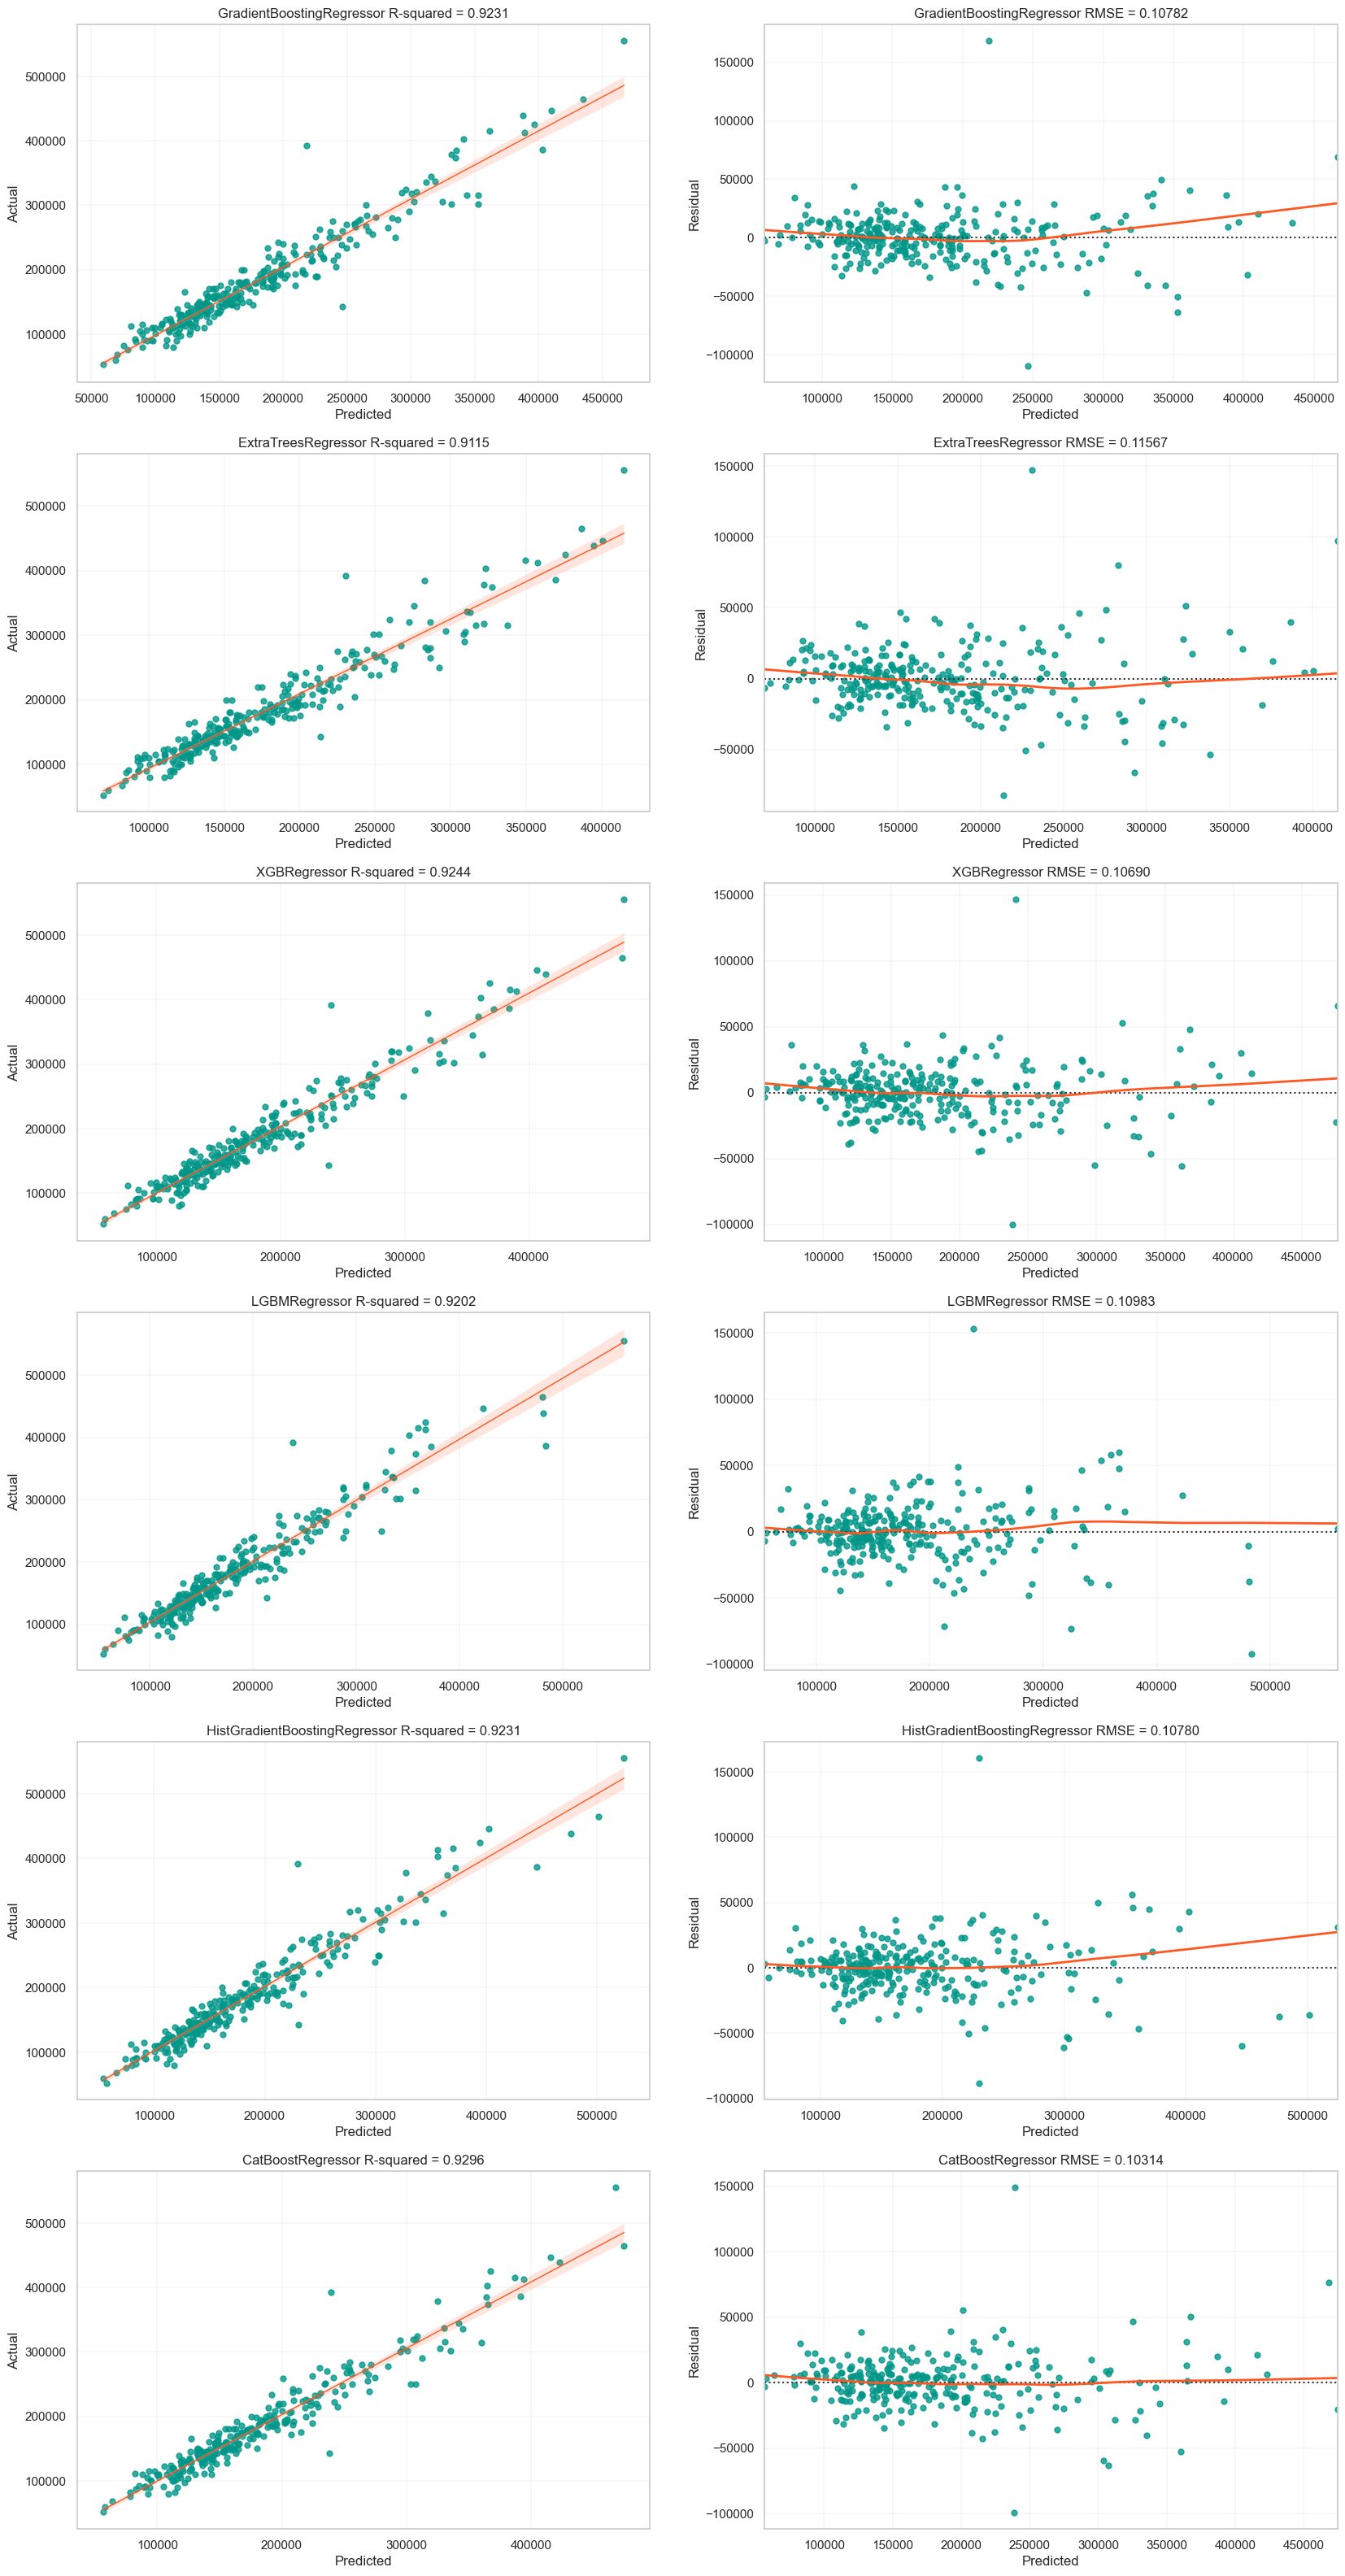

In [265]:
# Visualize the models with the best parameters chosen

fig, ax = plt.subplots(6, 2, figsize=(20, 40), dpi=100)

for i, algo in enumerate(algorithms):
    algo.fit(X_train, y_train)
    X_valid_predictions = algo.predict(X_valid)
    
    # Calculate R-squared and RMSE
    r2 = r2_score(y_valid, X_valid_predictions)
    rmse = mean_squared_error((y_valid), (X_valid_predictions), squared=False)
    
    # Plot the scatter plot on the first subplot
    sns.regplot(x=np.exp(X_valid_predictions), y=np.exp(y_valid), scatter_kws={'s':25}, line_kws={'color': palette[1], 'lw':1}, ax=ax[i, 0])
    ax[i, 0].set_title(f"{algo.__class__.__name__} R-squared = {r2:.4f}")
    ax[i, 0].set_xlabel("Predicted")
    ax[i, 0].set_ylabel("Actual")
    
    # Plot the residual plot on the second subplot
    sns.residplot(x=np.exp(X_valid_predictions), y=np.exp(y_valid), lowess=True, scatter_kws={'s':25}, line_kws={'color':palette[1],'lw':2}, ax=ax[i, 1])
    ax[i, 1].set_title(f"{algo.__class__.__name__} RMSE = {rmse:.05f}")
    ax[i, 1].set_xlabel("Predicted")
    ax[i, 1].set_ylabel("Residual")
    
plt.show()


### Avg. ensemble model  
the first ensemble model we will use is the average ensemble model. This model takes the average of the predictions from multiple models to make a final prediction. This model is useful when we have multiple models that are performing well on the dataset and we want to combine their predictions to make a final prediction.

Mean Squared Error:  0.010070732487262625
Root Mean Squared Error:  0.10035303925274323
Mean Absolute Error:  0.07423020654886978
R-squared:  0.9333712558786272


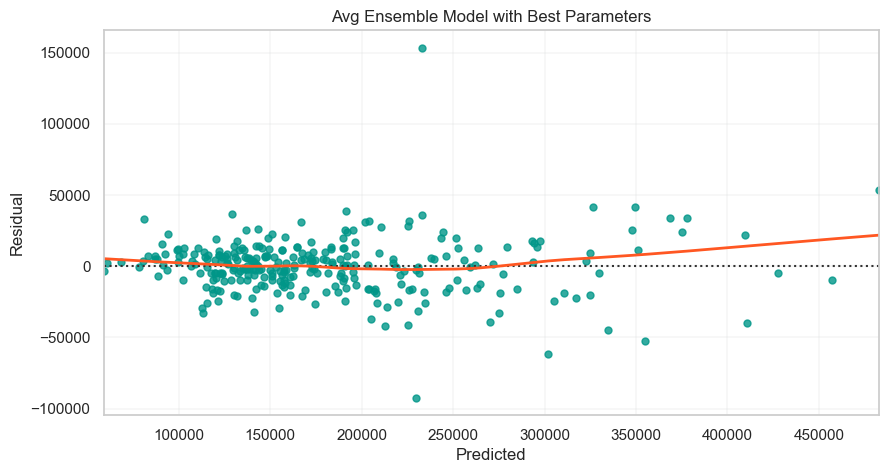

In [266]:
# create set for the validation score of each model 
validation_scores  = []


def validate_score(x_valid_predictions, model_name):
    # Calculate evaluation metrics
    mse = mean_squared_error(y_valid, x_valid_predictions)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_valid, x_valid_predictions)
    r2 = r2_score(y_valid, x_valid_predictions)

    # Print evaluation metrics
    print("Mean Squared Error: ", mse)
    print("Root Mean Squared Error: ", rmse)
    print("Mean Absolute Error: ", mae)
    print("R-squared: ", r2)

    # Create a dataframe of evaluation metrics
    eval_metrics = pd.DataFrame({'Metric': ['MSE', 'RMSE', 'MAE', 'R-squared'], 'Value': [mse, rmse, mae, r2]})

    # Visualize the final model
    plt.figure(figsize=(10, 5), dpi=100)
    sns.residplot(x=np.exp(x_valid_predictions), y=np.exp(y_valid), lowess=True, scatter_kws={'s': 25}, line_kws={'color': palette[1], 'lw': 2})
    plt.title(f"{model_name} Model with Best Parameters")
    plt.xlabel("Predicted")
    plt.ylabel("Residual")
    plt.show()
    
    # Return the evaluation metrics
    return {
        'Model': model_name,
        'MSE': mse,
        'RMSE': rmse,
        'MAE': mae,
        'R-squared': r2
        }


# Approach 1 avg 
X_valid_predictions = sum([algo.predict(X_valid) for algo in algorithms]) / len(algorithms)

# only use the best LGBM Regressor model from Algorithms 
# and use it to predict the test set
# X_valid_predictions = algorithms[4].predict(X_valid)

valid_scores = validate_score(X_valid_predictions, 'Avg Ensemble')
validation_scores.append(valid_scores)


#Get the ensemble predicted score on X_test
avg_model_predictions = sum([algo.predict(X_test) for algo in algorithms]) / len(algorithms)

avg_model_predictions = np.exp(avg_model_predictions)

### Linear regression predictions 
This approach is useful when we have a large number of models that are performing well on the dataset and we want to combine their predictions to make a final prediction. Using this approach, we can combine the predictions from all the models to make a final prediction.

Mean Squared Error:  0.009733498456513225
Root Mean Squared Error:  0.09865849409206094
Mean Absolute Error:  0.07264716799784836
R-squared:  0.9356024222781161


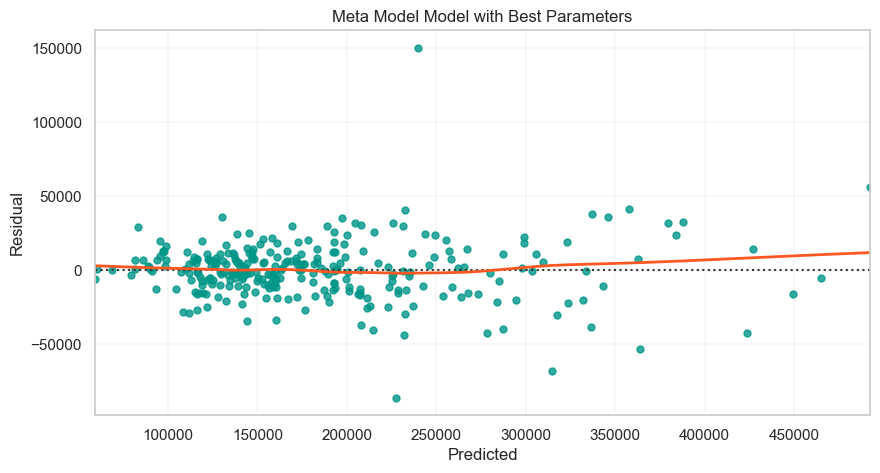

In [267]:
# Generate base model predictions for X_valid
X_valid_predictions = np.column_stack([algo.predict(X_valid) for algo in algorithms])

# Train the meta-model on X_valid predictions
meta_model = LinearRegression()
meta_model.fit(X_valid_predictions, y_valid)


# Generate base model predictions for the test set
X_test_predictions = np.column_stack([algo.predict(X_test) for algo in algorithms])

meta_model_valid_predictions = meta_model.predict(X_valid_predictions)

valid_scores = validate_score(meta_model_valid_predictions, 'Meta Model') 
validation_scores.append(valid_scores)
 
# Generate final predictions using the meta-model
meta_model_predictions = np.exp(meta_model.predict(X_test_predictions))

### Stacking Regressor 
This approach is unique in that it uses a meta-model to combine the predictions from the other models. This means the model can learn the best way to combine the predictions from the other models to make a final prediction. Adding a CV meta-model should improve the accuracy of our predictions.

#### Stacking Regressor with Linear Regression

Mean Squared Error:  0.010309305169739177
Root Mean Squared Error:  0.10153474858263636
Mean Absolute Error:  0.0744216671931785
R-squared:  0.931792840581112


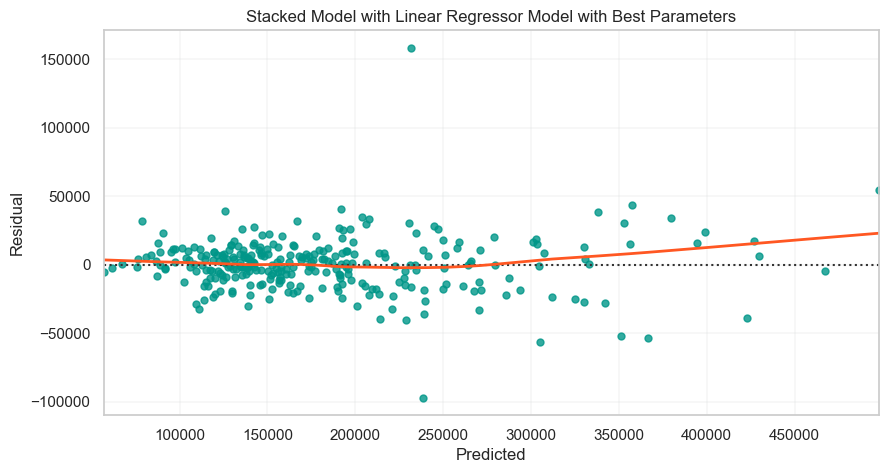

In [268]:
# Create a StackingRegressor with LinearRegression as the final estimator
stacked_model_lr = StackingRegressor(
    estimators=[(f'model_{i}', model) for i, model in enumerate(algorithms)],
    final_estimator=LinearRegression(),
    cv=5
)

stacked_model_lr.fit(X_train , y_train)

stacked_Linear_regressor_valid_predictions = stacked_model_lr.predict(X_valid)
valid_scores = validate_score(stacked_Linear_regressor_valid_predictions, 'Stacked Model with Linear Regressor')
validation_scores.append(valid_scores)
 
stacked_Linear_regressor_predictions = np.exp(stacked_model_lr.predict(X_test))

#### Stacking Regressor with Ridge Regression
the ridge regression model uses the L2 regularization technique to reduce the complexity of the model. This technique adds a penalty term to the loss function that penalizes large weights. This helps reduce overfitting and improve the generalization capabilities of the model.

Mean Squared Error:  0.01010840664573095
Root Mean Squared Error:  0.10054057213747568
Mean Absolute Error:  0.07388925744813403
R-squared:  0.9331220007357914


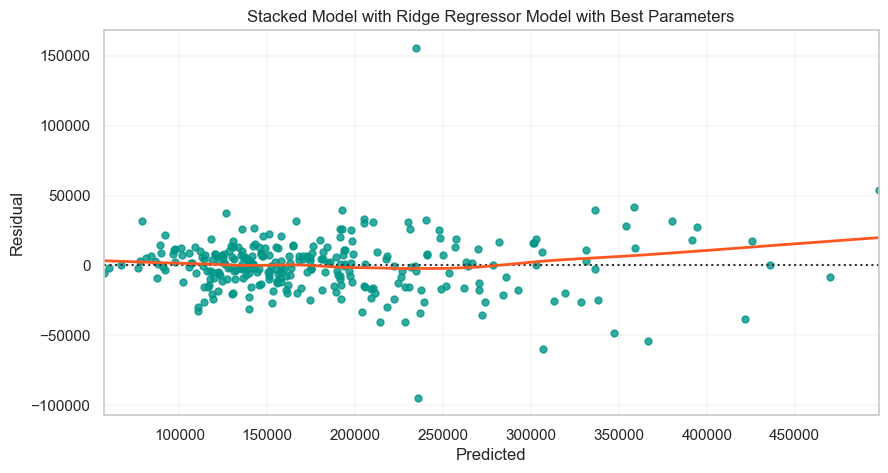

In [269]:
# Create StackingRegressors with Ridge as final estimators
stacked_model_ridge = StackingRegressor(
    estimators=[(f'model_{i}', model) for i, model in enumerate(algorithms)],
    final_estimator=Ridge(alpha=2.0),
    cv=5)

# Train the stacked models on the training data
stacked_model_ridge.fit(X_train, y_train)
stacked_model_ridge_valid_predictions = stacked_model_ridge.predict(X_valid)
valid_scores = validate_score(stacked_model_ridge_valid_predictions, 'Stacked Model with Ridge Regressor') 
validation_scores.append(valid_scores)
 
# Generate final predictions using the stacked models
stacked_ridge_predictions = np.exp(stacked_model_ridge.predict(X_test))

#### Stacking Regressor with Random Forest Regressor
stacking with random forest regressor can improve the accuracy of our predictions, as it combines the predictions by fitting a random forest regressor to the predictions from the other models. This allows the model to learn the best way to combine the predictions from the other models to make a final prediction.

Mean Squared Error:  0.012958485091932766
Root Mean Squared Error:  0.11383534201614526
Mean Absolute Error:  0.08630433633664801
R-squared:  0.914265661561059


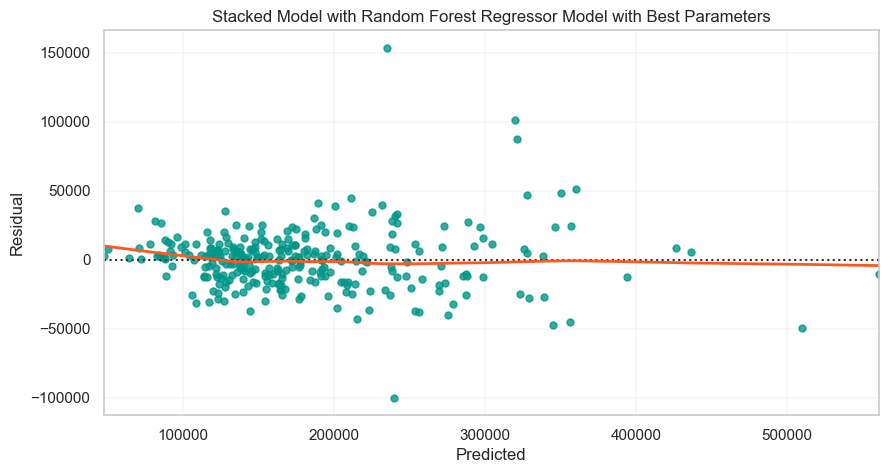

In [270]:
# create a StackingRegressor with RandomForestRegressor as the final estimator

stacked_model_rf = StackingRegressor(
    estimators=[(f'model_{i}', model) for i, model in enumerate(algorithms)],
    final_estimator=RandomForestRegressor(random_state=0),
    cv=5
)
stacked_model_rf.fit(X_train, y_train)
stacked_model_rf_valid_predictions = stacked_model_rf.predict(X_valid)
valid_scores = validate_score(stacked_model_rf_valid_predictions, 'Stacked Model with Random Forest Regressor') 
validation_scores.append(valid_scores)
 
stacked_rf_predictions = np.exp(stacked_model_rf.predict(X_test))

### LGBM Regressor
Using Gradient Boosting with LightGBM Regressor only

Mean Squared Error:  0.012061669682460505
Root Mean Squared Error:  0.10982563308472437
Mean Absolute Error:  0.08104377324149442
R-squared:  0.9201990615910377


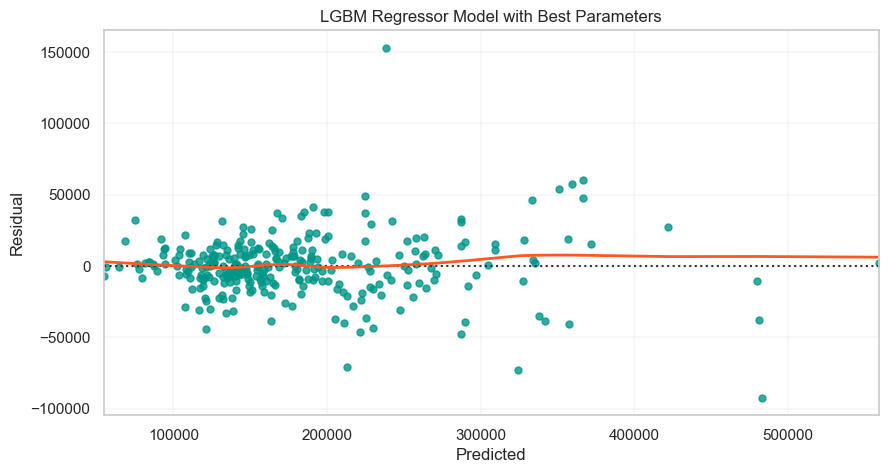

In [271]:
#Get the ensemble predicted score on X_test
# X_test_predictions = sum([algo.predict(X_test) for algo in algorithms]) / len(algorithms)


# Train the stacked models on the training data

X_validate_predictions_LGBM = algorithms[3].predict(X_valid)
valid_scores = validate_score(X_validate_predictions_LGBM, 'LGBM Regressor')
validation_scores.append(valid_scores)
 


X_test_predictions_LGBM = algorithms[3].predict(X_test)
X_test_predictions_LGBM = np.exp(X_test_predictions_LGBM)

### XGB Regressor
Using Gradient Boosting with XGB Regressor only. 

Mean Squared Error:  0.011426917171184998
Root Mean Squared Error:  0.10689675940450673
Mean Absolute Error:  0.07870337196116056
R-squared:  0.9243986332416269


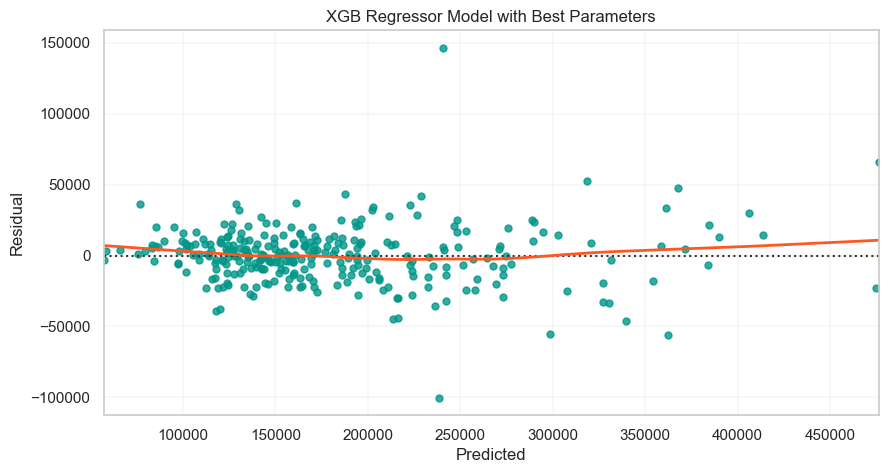

In [272]:
#Get the ensemble predicted score on X_test
# X_test_predictions = sum([algo.predict(X_test) for algo in algorithms]) / len(algorithms)

X_validate_predictions_XGB = algorithms[2].predict(X_valid)
valid_scores = validate_score(X_validate_predictions_XGB, 'XGB Regressor')
validation_scores.append(valid_scores)

X_test_predictions_XGB = algorithms[2].predict(X_test)
X_test_predictions_XGB = np.exp(X_test_predictions_XGB)

## Validation and Evaluation
check the performance of our models using cross-validation and other evaluation techniques. This will allow us to determine which models are performing well and which models need to be improved.

In [275]:
# print the validation scores for each model
pd.DataFrame(validation_scores).applymap(lambda x: f"{x:.5f}" if isinstance(x, float) else x).sort_values(by='R-squared', ascending=False)

Model      MSE     RMSE      MAE  \
1                                  Meta Model  0.00973  0.09866  0.07265   
0                                Avg Ensemble  0.01007  0.10035  0.07423   
3          Stacked Model with Ridge Regressor  0.01011  0.10054  0.07389   
2         Stacked Model with Linear Regressor  0.01031  0.10153  0.07442   
6                               XGB Regressor  0.01143  0.10690  0.07870   
5                              LGBM Regressor  0.01206  0.10983  0.08104   
4  Stacked Model with Random Forest Regressor  0.01296  0.11384  0.08630   

  R-squared  
1   0.93560  
0   0.93337  
3   0.93312  
2   0.93179  
6   0.92440  
5   0.92020  
4   0.91427

Here we see that the Meta Regressor model has the highest R-squared score and the lowest RMSE score. This indicates that the Meta Regressor ensemble model is the best performing model out of all the models we have trained so far. We will use this model to submit our predictions to the Kaggle competition! 

In [274]:
# Sample submission (to get right format)
submission=pd.read_csv('Dataset/sample_submission.csv')

# Add predictions
submission['SalePrice']=meta_model_predictions

# Output to csv
submission.to_csv('submission.csv', index=False)


# Best Entry! 0.12262